## Customer Propensity Modeling  For Bank Product
- Objective : 
    1. Help a marketing Executive at a large bank  understand which characteristics are best predictor of bank product purchase.
    2. Build a Predictive model to score potential customer.

## 1.0 Constrains

### 1.1 Modeling Constraints : 
- Modeling Type : Classification    
- Model Explainaibility : 
    - Explainable Model required
    - Black Box Models - Not Feasible because they are not explainable. Hence although they are generally more powerful, for explainability purpose they are excluded from the current scope.
        - e.g Excluded Models: Random Forest, SVM, DNN, ConvNets 
    - Candidate Models :
        - Decision Tree, Logistic Regression

### 1.2 Data Constraint :
- Primary Data : 
    - Dependent / Outcome Variable :  y (Does client subscribe to term deposit ?)
    - Independent / Predictor Variables :  21 Variables (Categorical, numerical)
- Imbalanced Data :  


### 1.3 Evaluation Metrics Constraint:
- Imbalanced Data specific Evaluation Metrics
- General constraints i.e accuracy leads to improper evaluation / modeling & final choice.

### 1.4 Framework Constraint : 
- This constraint is self-selected based on ease of use and data size.
- Scikit-learn. 
    - Scikit-Learn : Given that the Data-size is comparatively small, scikit-learn  is selected as the framework, given its comparative ease  or use and faster Iteration possiblity.
    - If Data Size is large and complex modeling is required, use of Tensorflow / GPU training or SparkML will be better option at the cost of comparatively longer development, iteration time and added complexity.
- StatsModel :
    - Scikit-learn provides more varied models(Forest, Boosting, Bagging, SVM, NNs), powerful parameter customisation and control. However the LR model generated by them have few model and model parameter statistics compared to StatsModel (i.e p value, 95% CI, marginal_effects ). Hence we will use StatsModel's LogisticRegression in the second part.



## 1. Data Load

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_data(path, delimiter=','):
    df = pd.read_csv(path, delimiter=delimiter)
    duplicateRows = df[df.duplicated()]

    print(f"\nLoading File : {path}")
    print(f' ...Rows: {len(df)}. Cols : {len(df.columns)}')
    if len(duplicateRows) > 0:
        print(
            f' ...WARNING: Duplicate Row Found. Total No of Duplicate Rows is  {len(duplicateRows)}')
        print(f'     ...Initiating Row Deduplication .....')
        df = df.drop_duplicates(keep='last')
        print(f'     ...Total No of unique rows is {len(df)}')

    return df


# customer propensity dataframe
cp_train_df = load_data('Data/bank-additional-full.csv', delimiter=';')
cp_test_df = load_data('Data/bank-additional.csv', delimiter=';')
cp_train_df_orig = cp_train_df.copy()
cp_test_df_orig = cp_test_df.copy()

# Drop Bechmark_purpose_only variables
discard_columns_for_benchmark_purpose_only = ['duration']
cp_train_df = cp_train_df.drop(
    columns=discard_columns_for_benchmark_purpose_only)
cp_test_df = cp_test_df.drop(
    columns=discard_columns_for_benchmark_purpose_only)

# View Sample Data
cp_train_df.head()



Loading File : Data/bank-additional-full.csv
 ...Rows: 41188. Cols : 21
     ...Initiating Row Deduplication .....
     ...Total No of unique rows is 41176

Loading File : Data/bank-additional.csv
 ...Rows: 4119. Cols : 21


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 2. Exploratory Data Analysis (EDA) :
-  Data Sanity Check :
-  Dependent / outcome Variables

### 2.1 Class Label Distribution 
- Y label distribution across Train / Test Data
- Observation : Imbalanced Data 
    - Proper Loss Function / Evaluation methodologies to suit Imblanaced Data to be used.    
    - Evaluation method to be used : 
        - Not to use accuracy.
        - Use F1-Score, Roc curve, sensitivity, specificity

Train Data : % of Customers who bought bank product 11.266271614532737 %
Test Data : % of Customers who bought bank product 10.949259529011895 %


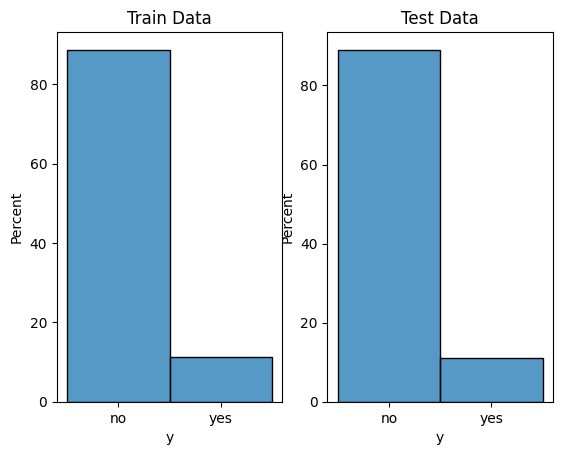

In [3]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(ncols=2)
sns.histplot(cp_train_df['y'], stat="percent",
             ax=axs[0]).set(title="Train Data")
sns.histplot(cp_test_df['y'], stat="percent", ax=axs[1]).set(title="Test Data")


def get_y_percentage(cp_train_df, data_type='Train'):
    print(
        f'{data_type} Data : % of Customers who bought bank product {len(cp_train_df[cp_train_df.y=="yes"]) * 100.0/ len(cp_train_df) } %')


get_y_percentage(cp_train_df)
get_y_percentage(cp_test_df, 'Test')


### 2.2 EDA : Univariate Analysis

In [4]:
# Variable Type Identification
discard_columns_for_benchmark_purpose_only = ['duration']
numerical_columns = ['age', 'campaign', 'pdays', 'previous']
numerical_socio_economic_columns = [
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical_columns = list(set(cp_train_df.columns) - set(
    discard_columns_for_benchmark_purpose_only + numerical_columns + numerical_socio_economic_columns))
cp_train_df.columns


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

#### 2.2.1 EDA Univariate Analysis : Categorical Variables  
- Categorical Value Validity Check : OK
- Missing Value Check : 


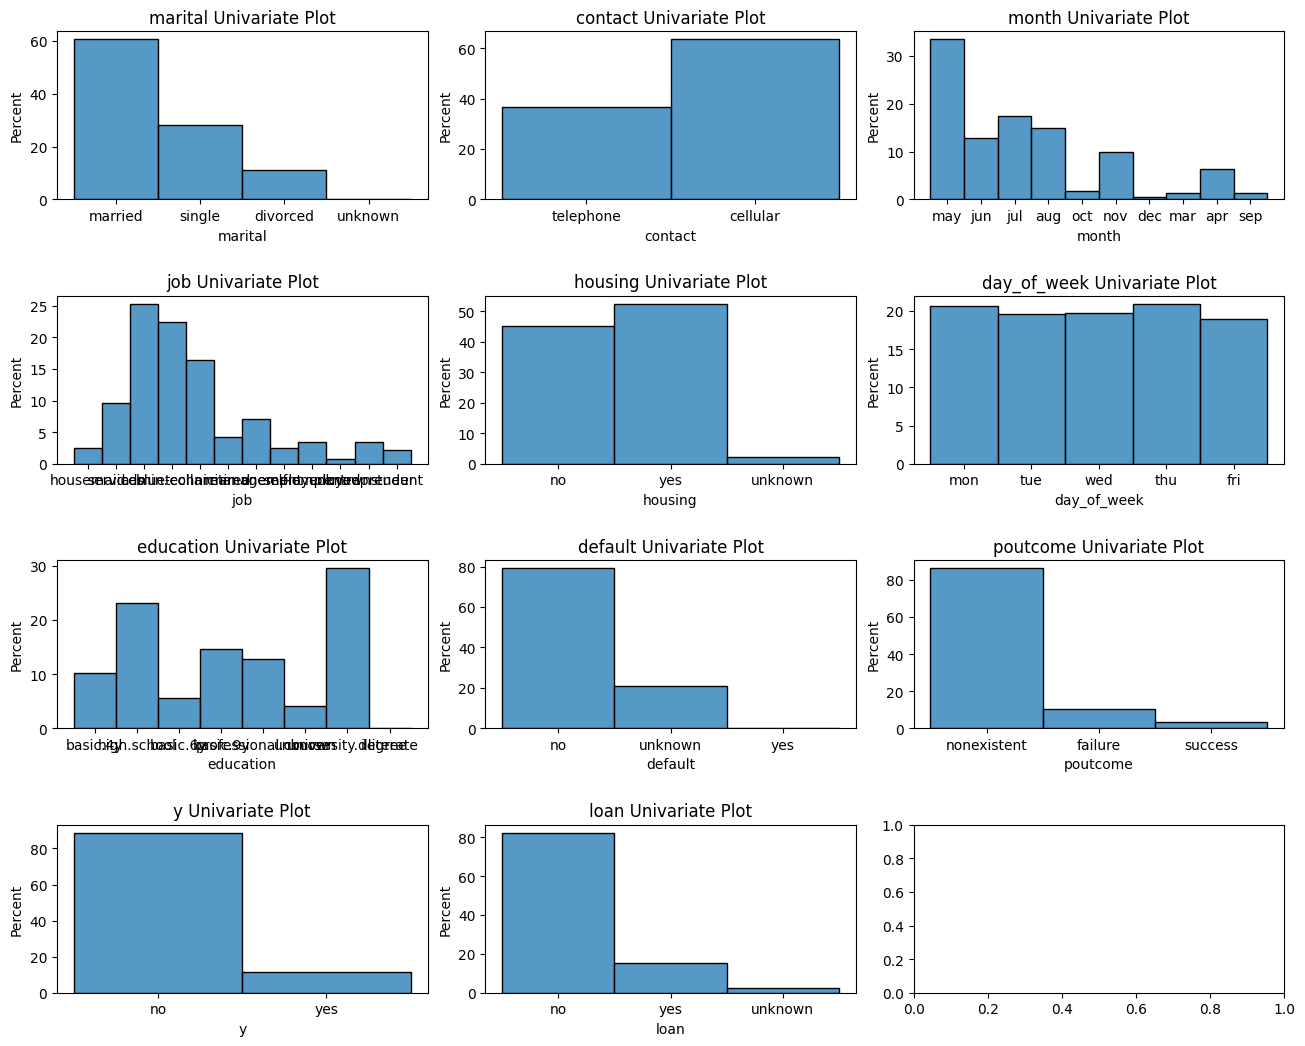

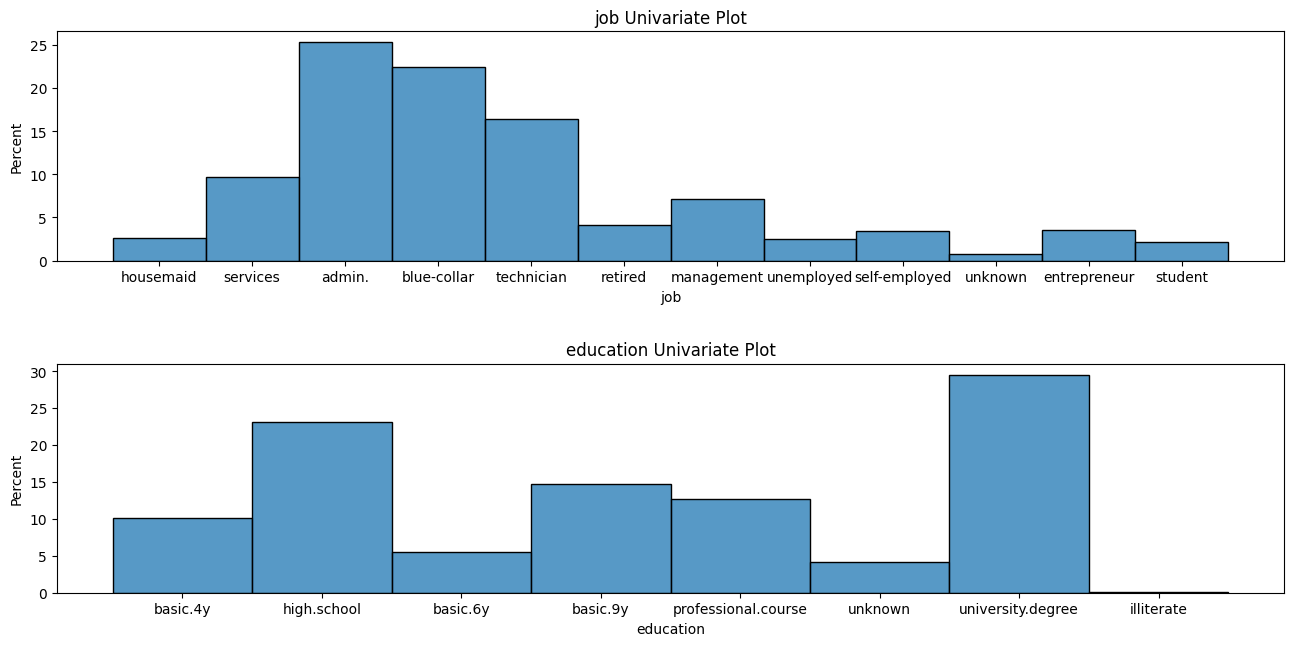

In [5]:
def univariate_plot_for_variables(df, categorical_columns, n_cols, figsize_x=5, figsize_y=6,
                                  top_in_betweeen_subplot_spacing=2.0, stat='percent'):

    row_idx, col_idx = 0, 0
    n_rows = int(np.ceil(len(categorical_columns)/n_cols))
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows,
                            figsize=(figsize_x, figsize_y))
    fig.tight_layout()
    plt.subplots_adjust(top=top_in_betweeen_subplot_spacing)

    for i, col in enumerate(categorical_columns):
        no_of_plots = i+1
        if n_cols == 1:
            sns.histplot(cp_train_df[col], stat=stat, ax=axs[row_idx]).set(
                title=col+" Univariate Plot")
        else:
            sns.histplot(cp_train_df[col], stat=stat, ax=axs[row_idx][col_idx]).set(
                title=col+" Univariate Plot")
        col_idx += 1

        if no_of_plots % n_cols == 0:
            row_idx += 1
            col_idx = 0


univariate_plot_for_variables(cp_train_df, categorical_columns,
                              n_cols=3, figsize_x=13, figsize_y=5,
                              top_in_betweeen_subplot_spacing=2.0)
univariate_plot_for_variables(cp_train_df, ['job', 'education'],
                              n_cols=1, figsize_x=13, figsize_y=3,
                              top_in_betweeen_subplot_spacing=2.0)


### 2.2 EDA Missing Values:

In [6]:
cp_train_df = cp_train_df.replace("unknown", np.nan)
cp_train_df.isnull().sum()

age                  0
job                330
marital             80
education         1730
default           8596
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [7]:
cp_test_df = cp_test_df.replace("unknown", np.nan)
cp_test_df.isnull().sum()


age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
day_of_week         0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

In [8]:
def get_missing_value_percentage(df, categorical_columns):

    print('Missing Values %')
    total_rows = len(df)

    for col in categorical_columns:
        missing_value_df = df[(df[col] == 'unknown') |
                              (df[col].isnull() == True)]
        missing_value_percentage = round(
            len(missing_value_df) * 100.0 / total_rows, 2)
        print(f'{col}: {missing_value_percentage}%')


get_missing_value_percentage(cp_train_df, categorical_columns)


Missing Values %
marital: 0.19%
contact: 0.0%
month: 0.0%
job: 0.8%
housing: 2.4%
day_of_week: 0.0%
education: 4.2%
default: 20.88%
poutcome: 0.0%
y: 0.0%
loan: 2.4%


### 2.2.1 Proprocessing : Missing Value Fixes:
- Options :
    - 1. Elimination : Record Elimintion or Variable Elimination
    - 2. Fill : Most Frequent Fill, Model Based Fill
    - 3. Special Indicator: e.g  missing_test means test was not required and has information with missing label
    - 4. Keep : Treat them as a class of their own
    - 5. Proportionate Fill. Fill missing values in the proportion they are represeted in the Data.

##### 2.2.1.0 No Missing Data:
- month : Last contacted month : No Missing Data
- poutcome : No Missing values
- day_of_week : No Missing values

#### 2.2.1.1 Eliminate Missing Data : 
- Why ?
    - Small enough records that they can be safely deleted. Does not reduce the data size significantly.
    - Given small amount, highly likely to be data errors in collection, entry, processing.
    - We want these error to not dilute or degrade prediction for ~98% of cases. Eliminating in favor of better modelling prediction.        - 
    - Also removing them did not significantly change the customer propensity %,  confirming that their removal was safe.
- What variables ?    
    - marital : 0.19%  missing data.

#### 2.2.1.2 Keep : As Separate Class: 
- Why ?    
    - Because there are large enough no. of records
    - Discarding them leads to substantial loss of training data
    - Given the higher amount of missing records, the  missing value is likely to be not a Data error but most likely the reality / practicality of the real world. 
    - If we eliminate them, then we have to be  very careful to exclude those customer's prediction  because the model did not scope them in.  If we do not, then because of data drift in training vs real world, the prediction is highly likely to be inaccurate.
- What variables to Keep ?
    - Default : Has credit in default ? :  ~20% Missing : Keep as separate class.
    - education : 4.2% Missing Data : Keep as separate class.
        


#### 2.2.1.3 Fill :
- loan : Has personal loan ? : Fill with mode value(no)
    - ~2.4% Missing Data. 
    - Because 80% of people do not have personal loan. We will consider it  safe to fill the missing data with majority or mode fill.
-  Porportionate Fill :
    - housing :  porportionate random fill because 2.4%
    - loan  :  proportionate random fill
    - education : proportionate random fill
    - job :  proportionate random fill


In [9]:
import numpy as np
categorical_variables_to_eliminate_record_if_has_missing_values = ['marital']
categorical_variables_to_mode_fill_if_has_missing_values = [
    'loan', 'job', 'housing', 'education']
categorical_variables_to_keep_as_separate_class = ['default']


def isNaN(num):
    return num != num


def fill_missing_values_with_proportionate_fill_random(df, col, percent_proportion=None):
    null_values = df[col].isnull().values
    unique_values, count_proportion = np.unique(
        df[col].values[~null_values], return_counts=1)
    percent_proportion = [p/count_proportion.sum() for p in count_proportion]
    print(unique_values, percent_proportion)
    df[col] = df[col].apply(lambda x: np.random.choice(
        unique_values,  p=percent_proportion) if x is None else x)

    fill_proportion = {val: proportion for val,
                       proportion in zip(unique_values, percent_proportion)}
    return df, fill_proportion


def get_missing_values_proportion(df, col):
    null_values = df[col].isnull().values
    unique_values, count_proportion = np.unique(
        df[col].values[~null_values], return_counts=1)
    percent_proportion = [round(p/count_proportion.sum(), 2)
                          for p in count_proportion]
    print(f'\n{col}\n   ...', unique_values, percent_proportion)
    return (list(unique_values), list(percent_proportion))


housing_fill_val, housing_fill_proportion = get_missing_values_proportion(
    cp_train_df, 'housing')
loan_fill_val, loan_fill_proportion = get_missing_values_proportion(
    cp_train_df, 'loan')
job_fill_val, job_fill_proportion = get_missing_values_proportion(
    cp_train_df, 'job')
education_fill_val, education_fill_proportion = get_missing_values_proportion(
    cp_train_df, 'education')


def get_rows_drop_count(df, previous_no_of_rows):
    no_of_rows_dropped = previous_no_of_rows - len(df)
    percent_of_rows_dropped = round(
        no_of_rows_dropped * 100.0 / previous_no_of_rows, 2)
    print(
        f'\nNo. of rows dropped : {no_of_rows_dropped} ({percent_of_rows_dropped} %) ')


def preprocess_missing_data(df):
    previous_no_of_rows = len(df)

    # Remove rows containing missing values
    df = df.dropna(axis=0, how='any', subset=['marital'])  # 0.14% data

    # Keep as missing_class
    df['default'].fillna('missing', inplace=True)

    # Replace :  Proportionate Replacement
    df['housing'] = df['housing'].apply(lambda x: np.random.choice(housing_fill_val,  p=housing_fill_proportion)
                                        if x is None or isNaN(x) else x)
    df['loan'] = df['loan'].apply(lambda x: np.random.choice(
        loan_fill_val,  p=loan_fill_proportion) if x is None or isNaN(x) else x)
    df['education'] = df['education'].apply(lambda x: np.random.choice(
        education_fill_val,  p=education_fill_proportion) if x is None or isNaN(x) else x)
    df['job'] = df['job'].apply(lambda x: np.random.choice(
        job_fill_val,  p=job_fill_proportion) if x is None or isNaN(x) else x)

    # df['loan'].fillna(missing_value_fill['loan'], inplace=True)
    # df = df.dropna(axis=0, how='any', subset=['job'] )
    # df = df.dropna(axis=0, how='any', subset=['housing'] )
    # df['education'].fillna('missing', inplace=True)
    get_rows_drop_count(df, previous_no_of_rows)

    return df


cp_train_df = preprocess_missing_data(cp_train_df)
cp_test_df = preprocess_missing_data(cp_test_df)

get_y_percentage(cp_train_df_orig, 'Train Data Pre Missing value Drop')
get_y_percentage(cp_train_df)

# Verification
assert cp_train_df.isnull().sum().sum() == 0, "ERROR : Missing Data still exists"
assert cp_test_df.isnull().sum().sum(
) == 0, "ERROR : Missing Data still exists in Test Data"



housing
   ... ['no' 'yes'] [0.46, 0.54]

loan
   ... ['no' 'yes'] [0.84, 0.16]

job
   ... ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed'] [0.26, 0.23, 0.04, 0.03, 0.07, 0.04, 0.03, 0.1, 0.02, 0.16, 0.02]

education
   ... ['basic.4y' 'basic.6y' 'basic.9y' 'high.school' 'illiterate'
 'professional.course' 'university.degree'] [0.11, 0.06, 0.15, 0.24, 0.0, 0.13, 0.31]

No. of rows dropped : 80 (0.19 %) 

No. of rows dropped : 11 (0.27 %) 
Train Data Pre Missing value Drop Data : % of Customers who bought bank product 11.266271614532737 %
Train Data : % of Customers who bought bank product 11.259003309324509 %


#### 2.2.2 EDA : Inadequate Variable Values
- Some values of the columns have very few values ranging from  0.01 to 0.04%. Hence we will remove those values from the categorical columns ltogether, because the data size for those values are too few to make reasonable judgement.


In [10]:
def get_too_few_values(df, min_percent=1):
    min_count = int(min_percent * len(df) / 100.0)
    print("Too Few Values EDA\n")
    for col in list(df.columns):
        if cp_train_df[col].dtype in [int, float] or \
                cp_train_df[col].value_counts().loc[lambda x: x < 100].reset_index()[col].sum() <= 0:
            continue

        print(f"\n{col}")
        small_values_df = df[col].value_counts(
        ).loc[lambda x: x < min_count].reset_index()
        small_values_df['percent'] = small_values_df[col].apply(
            lambda x: str(round(x*100.0/len(df), 2))+'%')
        print(small_values_df)


get_too_few_values(cp_train_df, min_percent=2)


Too Few Values EDA


education
        index  education percent
0  illiterate         18   0.04%

default
  index  default percent
0   yes        3   0.01%


#### 2.2.2.1 Fix : Inadequate Variable Values

In [11]:
def remove_too_few_values_from_variables(df, cols_to_remove_too_few_values_from):
    previous_no_of_rows = len(df)
    for col in list(df.columns):
        if col in cols_to_remove_too_few_values_from.keys():
            for val_to_remove in cols_to_remove_too_few_values_from[col]:
                df = df[df[col] != val_to_remove]

    get_rows_drop_count(df, previous_no_of_rows)
    return df


# cols_to_remove_too_few_values_from = {'education': ['illiterate'], 'default': ['yes']}
cols_to_remove_too_few_values_from = {'default': ['yes']}
cp_train_df = remove_too_few_values_from_variables(
    cp_train_df, cols_to_remove_too_few_values_from)
cp_test_df = remove_too_few_values_from_variables(
    cp_test_df, cols_to_remove_too_few_values_from)



No. of rows dropped : 3 (0.01 %) 

No. of rows dropped : 1 (0.02 %) 


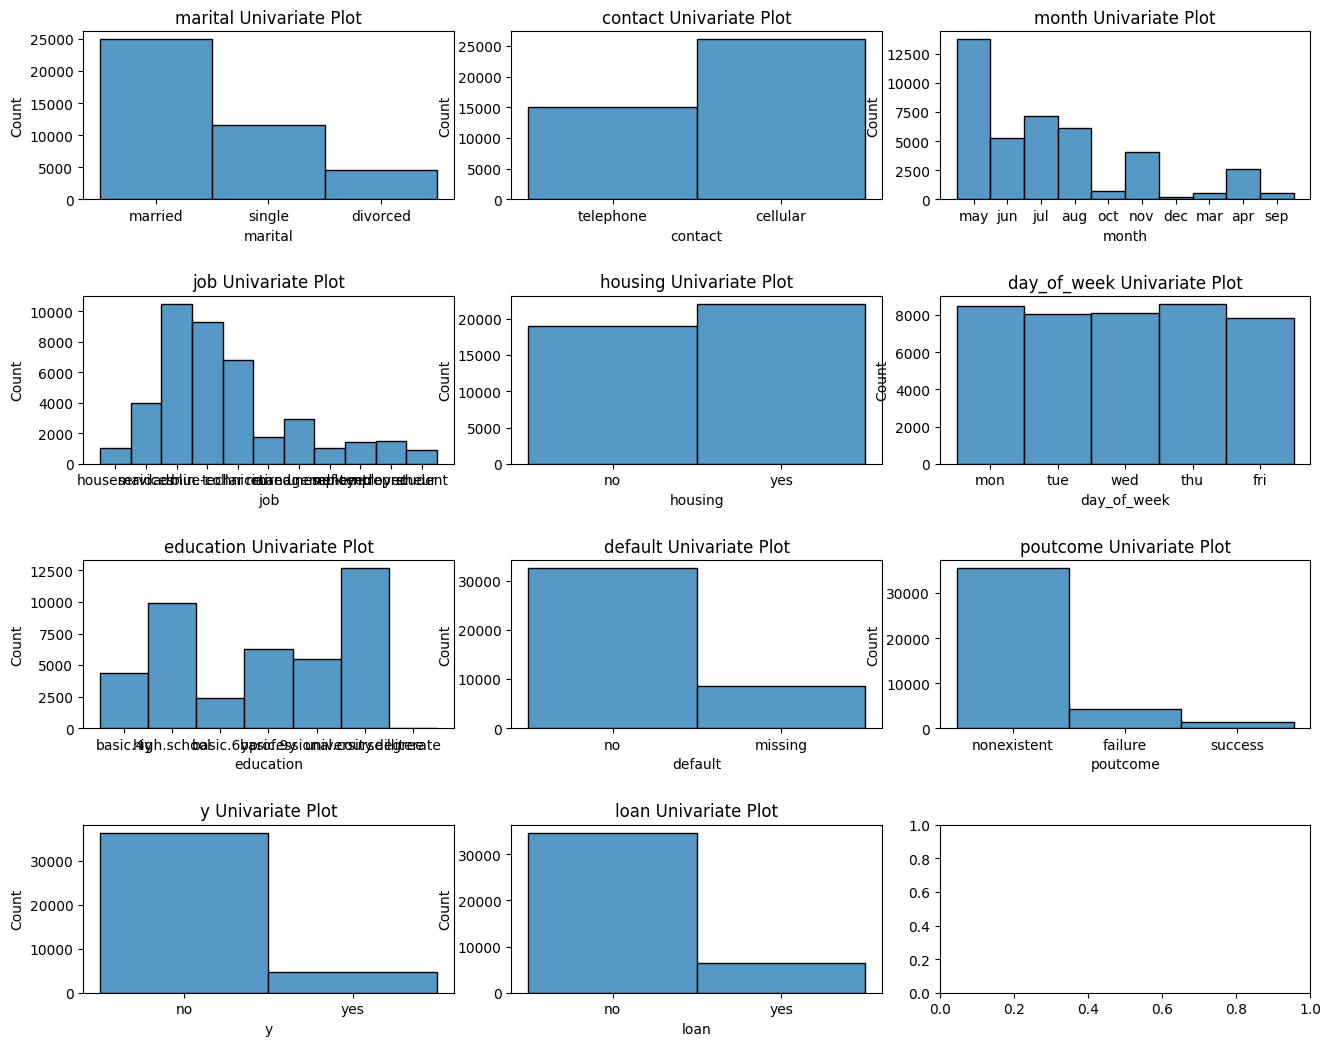

In [12]:
univariate_plot_for_variables(cp_train_df, categorical_columns,
                              n_cols=3, figsize_x=13, figsize_y=5,
                              top_in_betweeen_subplot_spacing=2.0, stat='count')

cols = list(cp_train_df.columns)
cols.remove('y')
cols_ckpt_data_cp_train_post_missing_value = cols.copy()
ckpt_data_cp_train_post_missing_value = cp_train_df.copy()
ckpt_data_cp_test_post_missing_value = cp_test_df.copy()


#### 2.2.3 PreProcessing Candidates from EDA : Categorical Variables

##### 2.2.3.1 Candidates : One Hot Categorical Variables
- Default : Has credit in default ?
- month : Last contacted month
- education :
- job :
- poutcome 
- day_of_week
- marital

##### 2.2.3.2 Candidates :Binary Variables
- Housing (yes/no)        
- loan : Has personal loan ?    
- contact : (cellular/telephone - contacted via cell or telephone)

##### 2.2.3.3 Candidates : Ordinal Vairables :
- Why ?
    - so that they capture the ranking information contained in them, which is not captured by categorical variables.    
- Candidate Variablse :
    - Education can be transformed into ordinal variables

    
##### 2.2.3.4 Candidates : Feature Engineering
- Education into ordinal variables
- Month into seasons




#### 2.2.4 EDA: Numerical Variables

##### 2.2.4.1 EDA: Data Sanity Check 
- Valid Range Check : 
    - Age : Yes Valid Range, a person can be 17-98 years old.
    - Campaign : Outliers present : 56 looks odds
    - pdays :  Not valid. Contains 999 (Need to be transformed)
    - previous : No of contacts performed  before campaign.

##### 2.2.4.2 EDA: Missing Data Check 
- Missing Data Check : No missing values in numerical variables. 


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41093.0,41093.0,41093.0,41093.0,41093.0,41093.0,41093.0,41093.0,41093.0
mean,40.0,3.0,963.0,0.0,0.0,94.0,-41.0,4.0,5167.0
std,10.0,3.0,187.0,0.0,2.0,1.0,5.0,2.0,72.0
min,17.0,1.0,0.0,0.0,-3.0,92.0,-51.0,1.0,4964.0
25%,32.0,1.0,999.0,0.0,-2.0,93.0,-43.0,1.0,5099.0
50%,38.0,2.0,999.0,0.0,1.0,94.0,-42.0,5.0,5191.0
75%,47.0,3.0,999.0,0.0,1.0,94.0,-36.0,5.0,5228.0
max,98.0,56.0,999.0,7.0,1.0,95.0,-27.0,5.0,5228.0


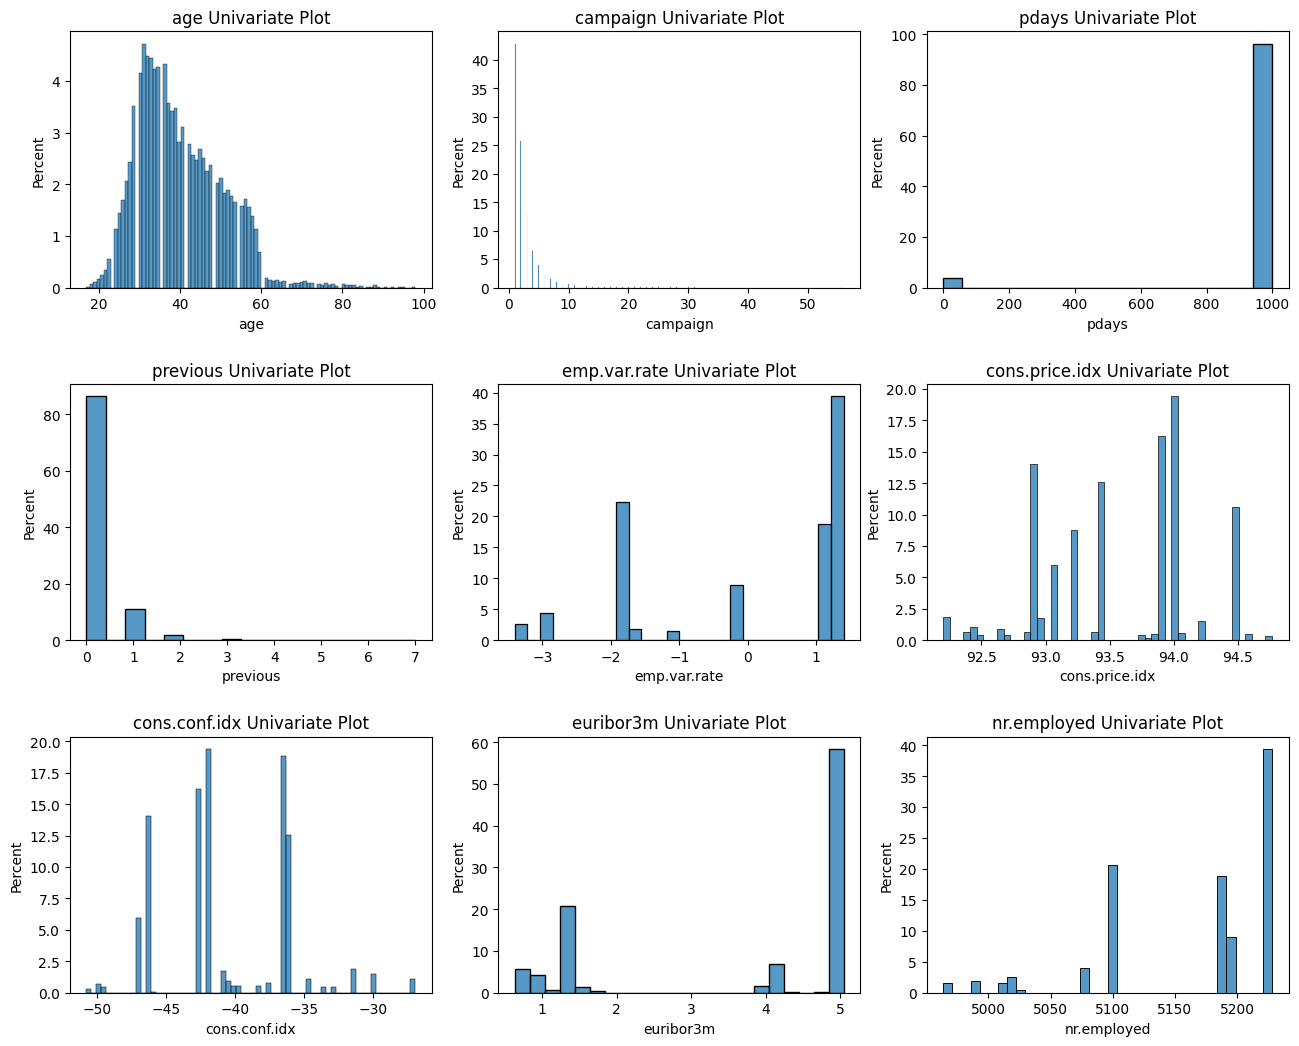

In [13]:
numerical_columns = ['age', 'campaign', 'pdays', 'previous']
numerical_socio_economic_columns = [
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

all_numerical_columns = numerical_columns + numerical_socio_economic_columns

univariate_plot_for_variables(cp_train_df, all_numerical_columns,
                              n_cols=3, figsize_x=13, figsize_y=5,
                              top_in_betweeen_subplot_spacing=2.0)

cp_train_df[all_numerical_columns].describe().round()


#### 2.2.5 PreProcessing : EDA Numerical Variables

##### 2.2.5.1 Data Distribution Fix:
- Fixing Odd Distribution: pday
- pdays  rather seems will be  better represented as binary variables. pcontacted i.e client was previously contacted or not
- poutcome : Because > 95% data for this column is non existing, we will remove this column

In [14]:
cols = list(ckpt_data_cp_train_post_missing_value.columns)
cols.remove('y')
cols_ckpt_data_cp_train_post_missing_value = cols.copy()
cp_train_df = ckpt_data_cp_train_post_missing_value.copy()
cp_test_df = ckpt_data_cp_test_post_missing_value.copy()


def transform_pday_to_binary(df):
    df['pcontacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
    return df


cp_train_df = transform_pday_to_binary(cp_train_df)
cp_test_df = transform_pday_to_binary(cp_test_df)


##### 2.2.5.2 PreProcessing Candidates : EDA Numerical Variables
- Outlier Fix : Required
    - campaign : no_of_cur_contacts_made
    - previous : no_of_prev_campaign_contacts_made
- Skewed Data Distribution Fix : Required
    - Log Transformation to make data normal distribution possible , but not done in favor of easier  comprehensibility. 
        - campaign : no_of_cur_contacts_made : 
        - previous : no_of_prev_campaign_contacts_made    
- Feature Scaling : Required
    - nr.employed
    - cons.conf.idx
    - cons.price.idx
    - euribor3m
    - age
- Odd Numerical Variables :
    - pdays (no of days past previous campaign contact): > 95% of data is 999
        - 999 means client was not previously contacted. 
        - Good candidate for converting to categorical variable.



#### 2.2.6 Preprocessing:  Outliers
- Generally outlier causes issues with modeling down the pipeline with harder convergence to some models i.e Logistic Regression, Linear Regression especially sensitive to  outliers. Hence we will fix them here.
- Possible solutions are
    - Replacement :
        - Clipping (Flooring or Capping)
        - Fill (Median / Mean/ Model) 
    - Rejection: Remove Data containing outliers
    - Accept:  Accept as separate unique class
        - Leave as-is
        - Treat as separate class
    - Transform : 
        - Log Transformation
        - Binning



##### 2.2.6.1 Outlier PreProcessing Choice : Preservation
- Preserving : 
    - Preserving outlier because the propensity at ~10% itself is an relatively outlier phenomenon and hence the outliers can in fact be signal rather than noise itself.
    - To Do in future : Other option, will be to do Model Comparision with / without outlier removal and compare them.
- Variables to Keep:
    - previous : ~14% outliers
    - campaign : ~6% outliers        
    - age : ~1% outliers
    - cons.conf.idx: ~1% outliers
- Variables to modify :
    - pdays : Since almost all of the values are "not previously contacted", we will  transform this to binary categorical variable.

In [15]:
def clip_to_max_nth_percentile(df, column, nth):
    nth_percentile = np.percentile(df[column], nth)
    df[column] = df[column].apply(lambda x: nth_percentile if x > nth_percentile else x)
    print(f"Clipped to {nth_percentile}")
    return df


def clip_to_n_sd_away(df, column, n_sd_away):
    mean = np.mean(df[column])
    std = np.std(df[column])

    lower_bound, upper_bound = mean - n_sd_away * std, mean + n_sd_away * std
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else x)
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else x)
    print(f"Clipped to [{lower_bound}, {upper_bound}] ")
    return df


def get_outlier_count_via_tukey_method(df):
    total_rows = len(df)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    outlier_count_df = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False)
    outlier_count_df = pd.DataFrame(outlier_count_df, columns=["outlier_count"])
    outlier_count_df["%"] = outlier_count_df["outlier_count"].apply(
        lambda x: str(round(x * 100.0 / total_rows, 2)) + "%"
    )
    return outlier_count_df


cp_train_df["pdays"] = cp_train_df["pdays"].apply(lambda x: 1 if x == 999 else 0)
if "pdays" in all_numerical_columns:
    all_numerical_columns.remove("pdays")
if "pdays" not in categorical_columns:
    categorical_columns.append("pdays")

get_outlier_count_via_tukey_method(cp_train_df[all_numerical_columns])


,outlier_count,%
previous,5606,13.64%
campaign,2396,5.83%
age,468,1.14%
cons.conf.idx,444,1.08%
emp.var.rate,0,0.0%
cons.price.idx,0,0.0%
euribor3m,0,0.0%
nr.employed,0,0.0%


### 2.3 EDA : Bivariate Analysis

#### 2.3.1 Bivariate EDA : Categorical variables (vs Class Label)


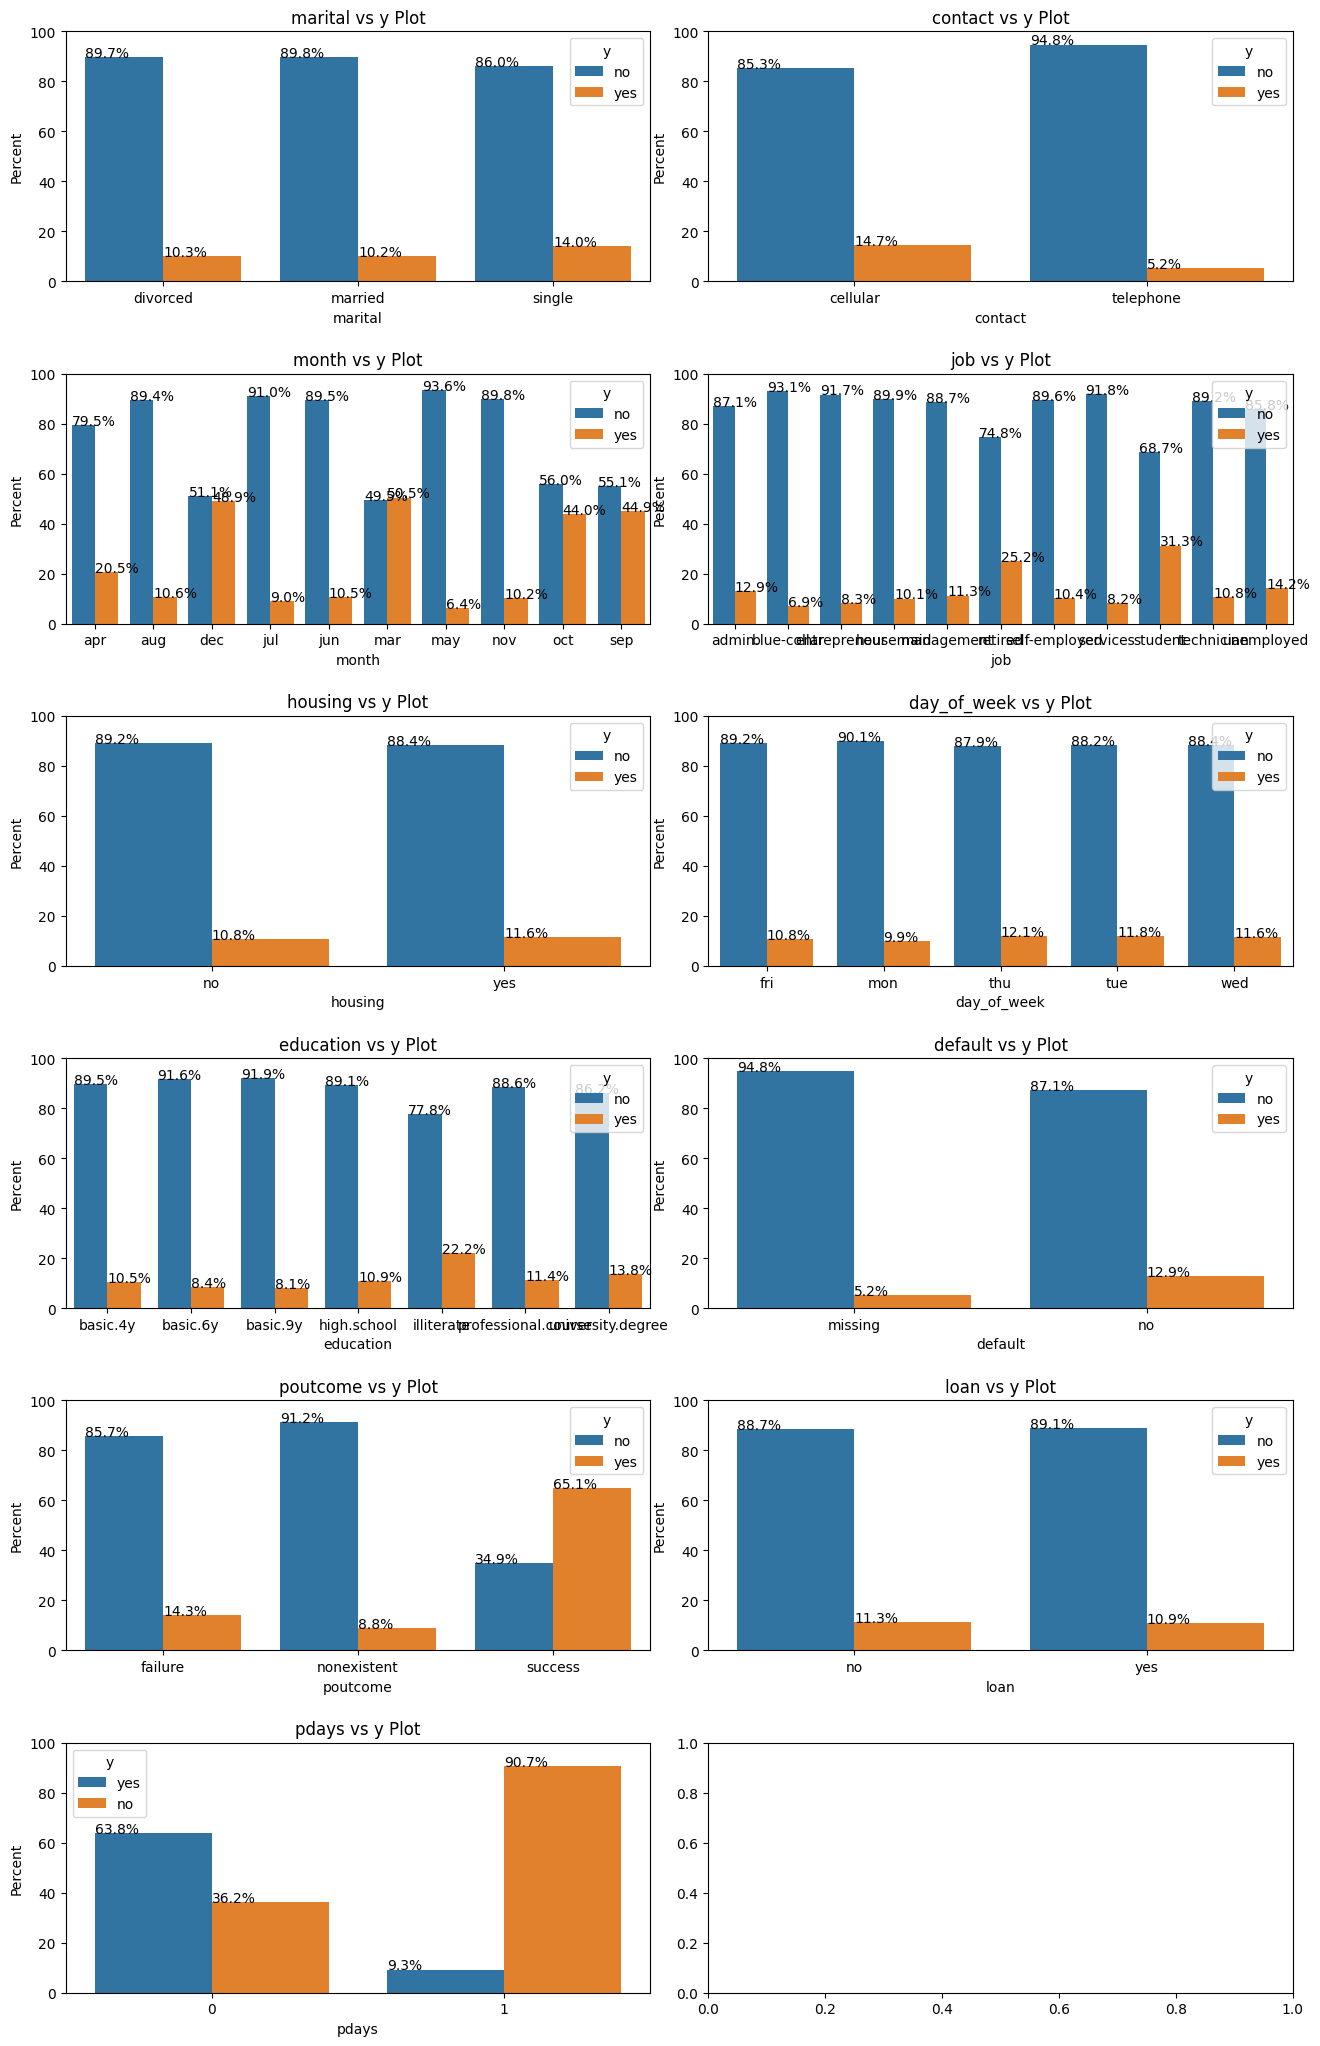

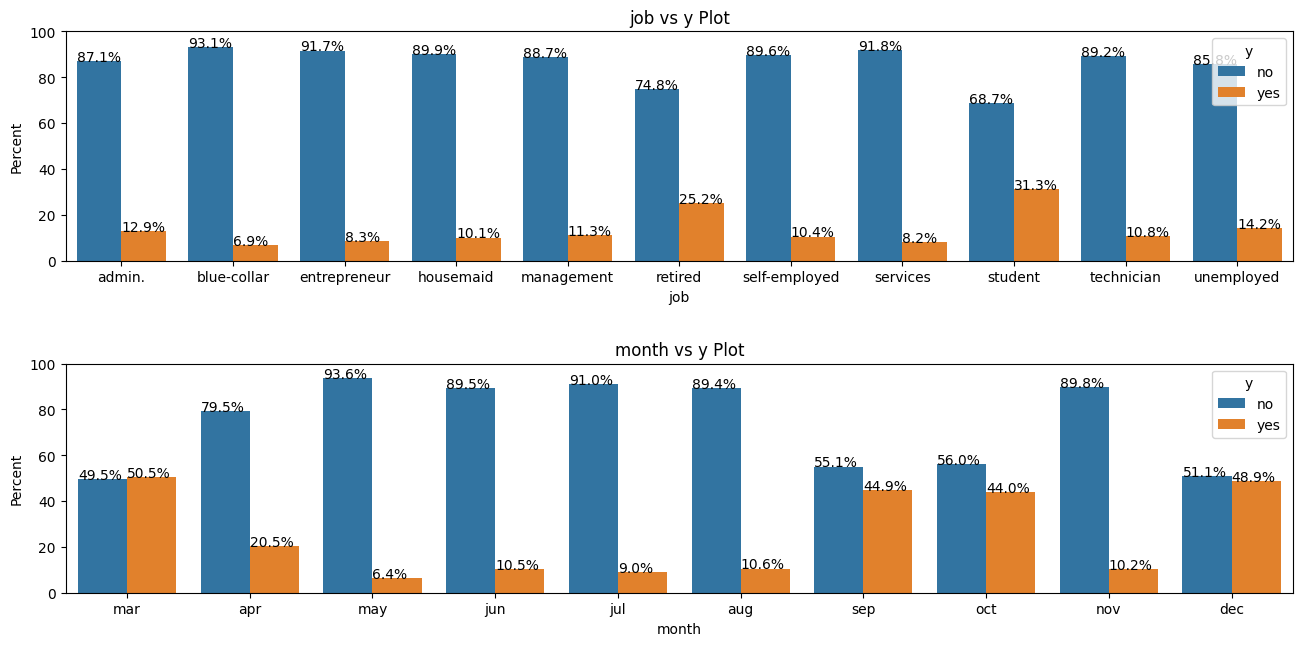

In [16]:
def bivariate_plot_for_categorical_variables(
    df,
    categorical_columns,
    outcome_variable,
    n_cols,
    figsize_x=5,
    figsize_y=6,
    top_in_betweeen_subplot_spacing=2.0,
    order=None,
):
    if outcome_variable in categorical_columns:
        categorical_columns.remove(outcome_variable)

    row_idx, col_idx = 0, 0
    n_rows = int(np.ceil(len(categorical_columns) / n_cols))
    # print(f' n_rows {n_rows} n_cols {n_cols}')
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(figsize_x, figsize_y))
    fig.tight_layout()
    plt.subplots_adjust(top=top_in_betweeen_subplot_spacing)

    for i, col in enumerate(categorical_columns):
        no_of_plots = i + 1
        # print(row_idx, col_idx, no_of_plots, col)
        cur_row_col_axes = axs[row_idx] if n_cols == 1 else axs[row_idx][col_idx]

        feature, target = col, outcome_variable
        new_df = df[[feature, target]].copy()
        new_df = new_df.groupby(feature)[target].value_counts(normalize=True)
        new_df = new_df.mul(100).rename("Percent").reset_index()
        new_df
        if order and col in order.keys():
            g = sns.barplot(x=feature, y="Percent", hue=target, data=new_df, ax=cur_row_col_axes, order=order[col])
        else:
            g = sns.barplot(x=feature, y="Percent", hue=target, data=new_df, ax=cur_row_col_axes)
        g.set(title=f"{col} vs {outcome_variable} Plot")
        g.set_ylim(0, 100)

        for p in g.patches:
            txt = str(p.get_height().round(1)) + "%"
            txt_x = p.get_x()
            txt_y = p.get_height()
            g.text(txt_x, txt_y, txt)

        # sns.catplot(data=cp_train_df, y=col, x=outcome_variable, kind='strip', ax=cur_row_col_axes).set(title=col+" Bivariate Plot")
        # sns.countplot(hue=outcome_variable, y=col,  data=cp_train_df,  ax=cur_row_col_axes).set(title=col+" Bivariate Plot")
        # dex.count("month", split="y", data=cp_train_df, normalize='month',
        # stacked=True,  title='month vs y', split_order=['yes', 'no'], ax=cur_row_col_axes)
        # sns.stripplot(data=cp_train_df, y=col, x=outcome_variable,  ax=cur_row_col_axes).set(title=col+" Bivariate Plot")
        col_idx += 1

        if no_of_plots % n_cols == 0:
            row_idx += 1
            col_idx = 0


bivariate_plot_for_categorical_variables(
    cp_train_df, categorical_columns, "y", n_cols=2, figsize_x=13, figsize_y=10, top_in_betweeen_subplot_spacing=2.0
)

## Replot plots with large unique values for better visibility
bivariate_plot_for_categorical_variables(
    cp_train_df,
    ["job", "month"],
    "y",
    n_cols=1,
    figsize_x=13,
    figsize_y=3,
    top_in_betweeen_subplot_spacing=2.0,
    order={"month": ["mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]},
)



#### 2.3.2 Bivariate EDA : Categorical variables (Inter-variables with Class Label as hue)
- To find out interaction terms 
- Future To Dos

#### 2.3.3 Bivariate EDA : Numerical variables

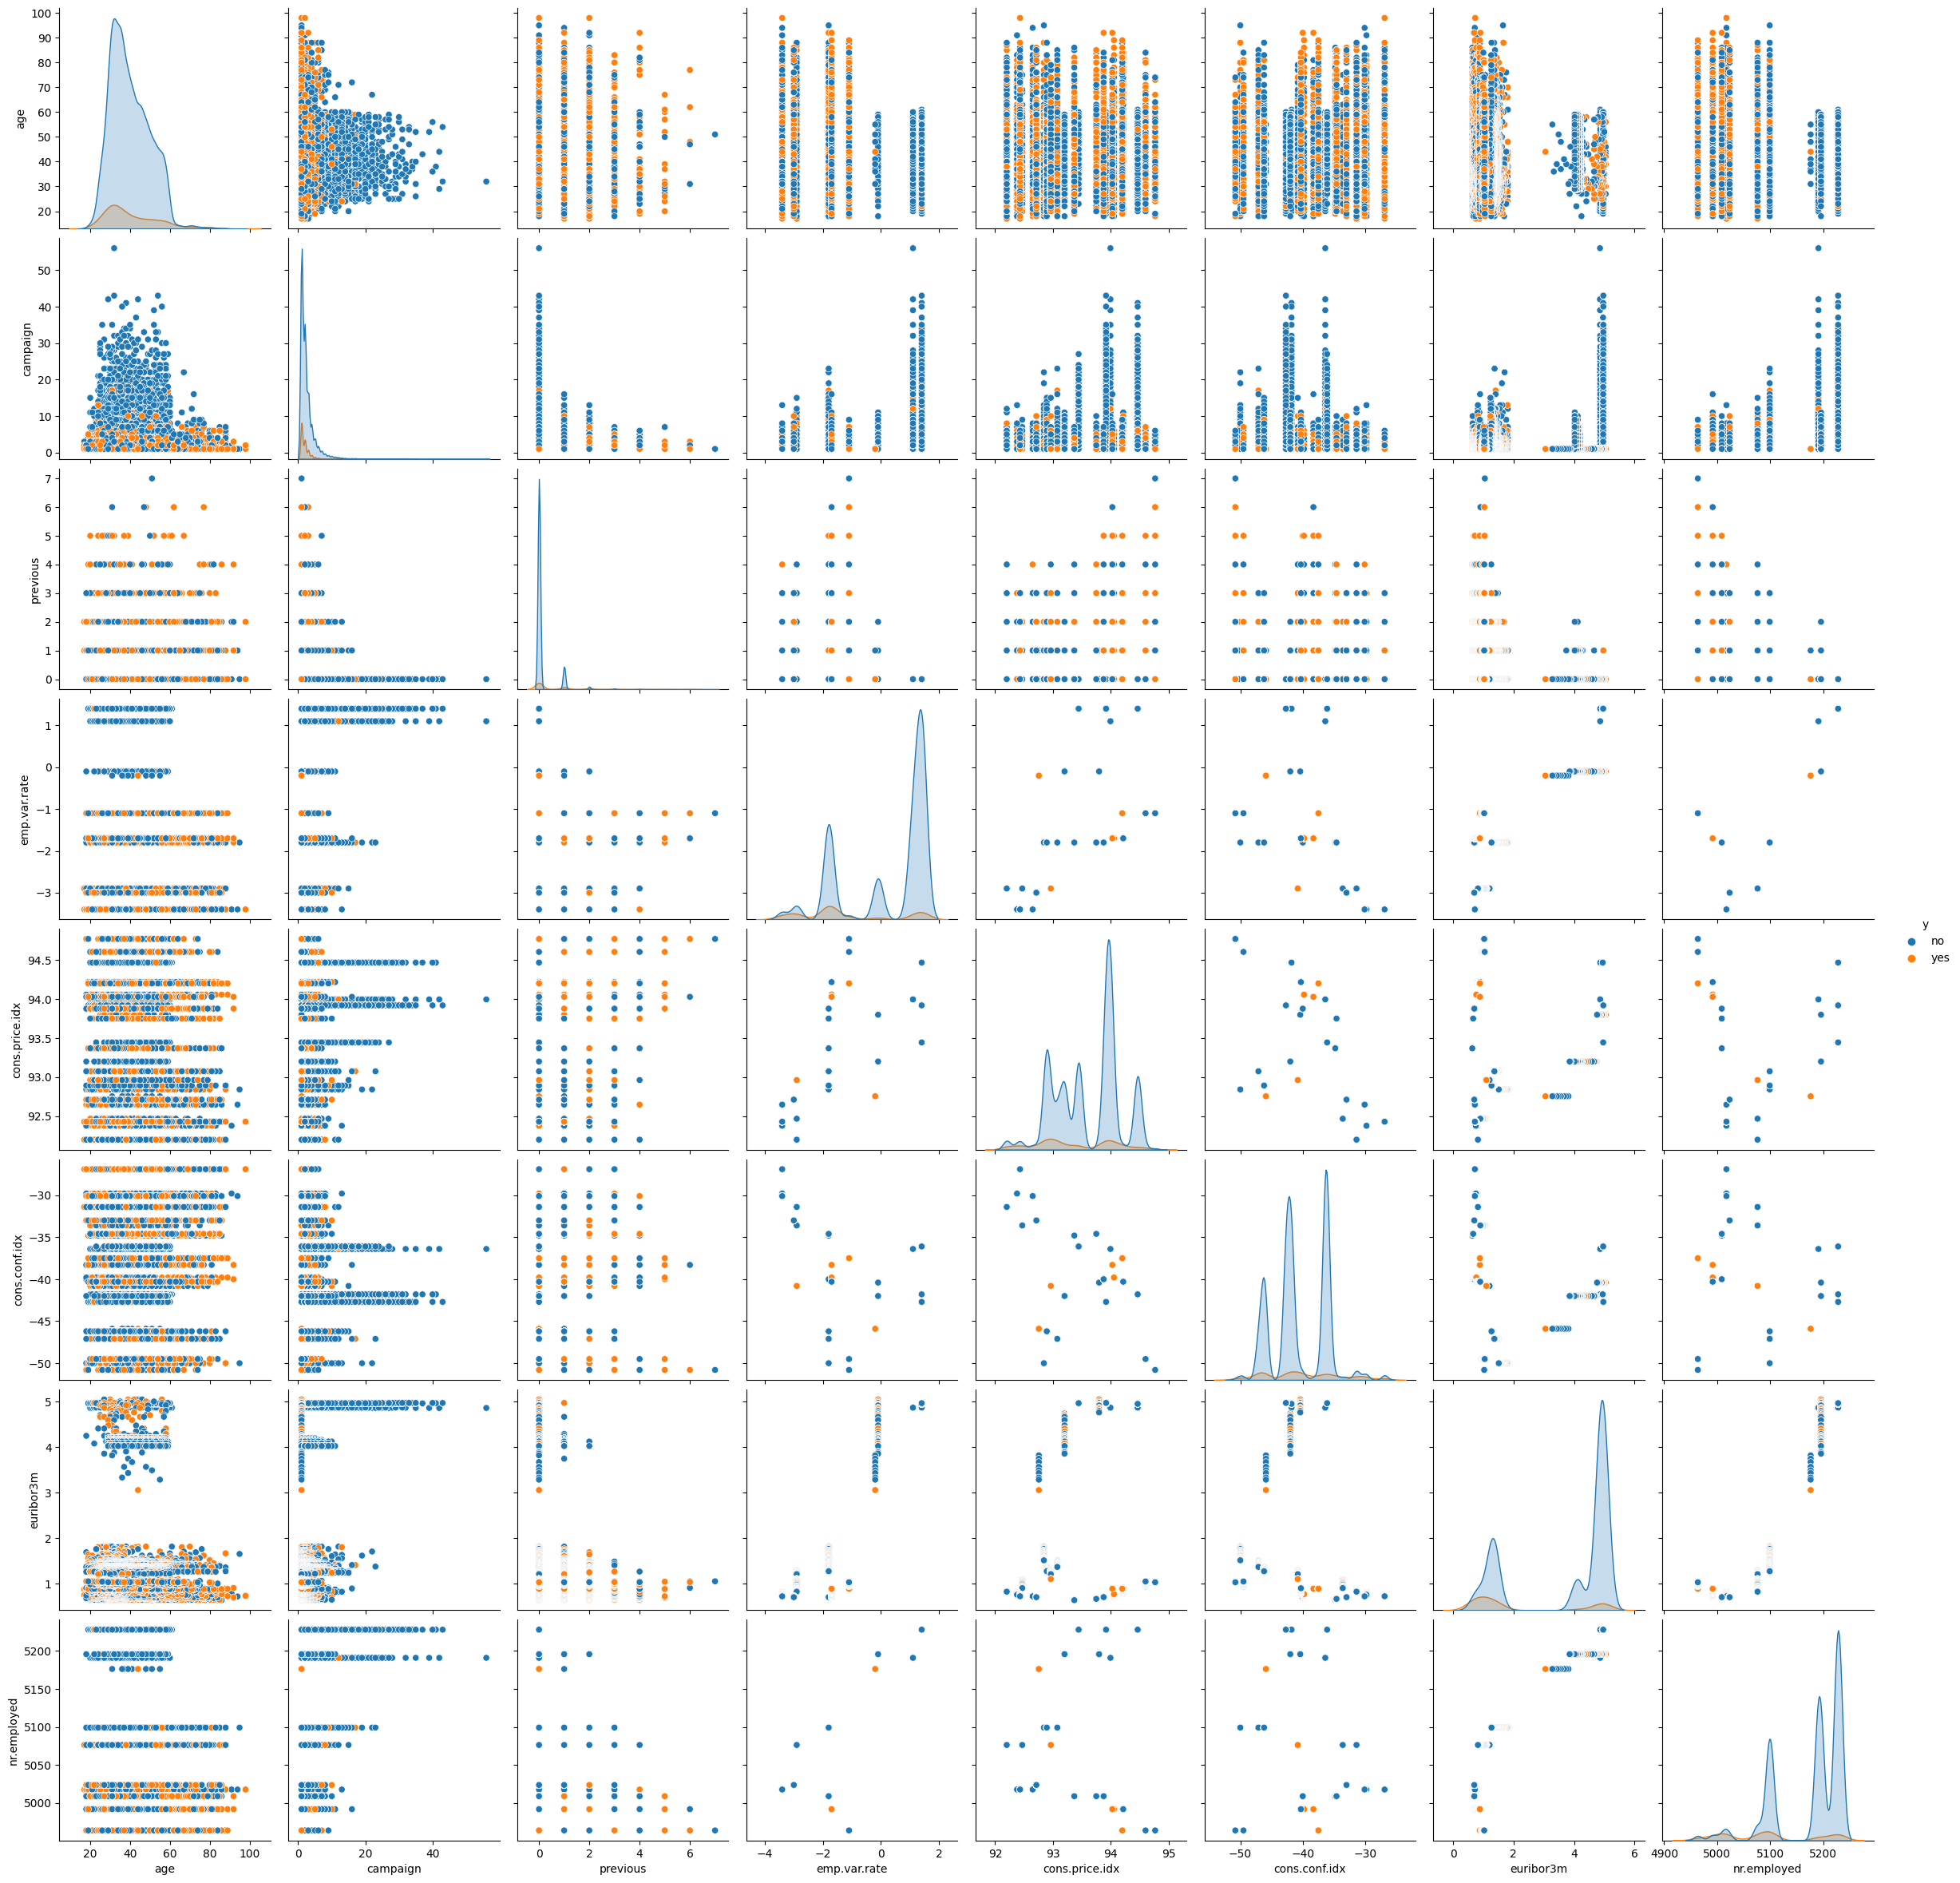

In [17]:
cur_nvars = all_numerical_columns
sns.pairplot(cp_train_df[cur_nvars + ["y"]], vars=cur_nvars, hue="y", size=3)


### 2.4 EDA General Observations : 
- default : 
    - People who have not defaulted are twice more likely to open accounts than missing ones. (12% vs 5%)
    - People who have defaulted  have no customer account opening propensity (AOP). (0%)
- housing: Makes no difference on customer acount opening propensity.
- Education :
    - Illiterates : Have twice higher propensity than other groups for AOP (acount opening propensity). (22% vs 10%)
- poutcomes : 
    - If previous marketing has been succesful, then those person are signficantly highly likely for AOP (65% vs 8-13%)
- marital status:
    - Single Individuals are slightly more  likely for AOP (14% vs 10%)
- day : tuesday/ wednesday / thursday  are more likely for AOP (12% vs 10%)
- cellular :
    - People contacted in cellular are thrice more likely for AOP (15% vs 5%)
- pdays : 
    - People contacted  previsouly have significantly higher AOP propensity (64% vs 10%)
- job : 
    - retired(25%) and students(31%)  have high AOP propensity vs 11% avg.
    - Blue collar(7%) and services(8%) have low AOP propensity vs 11% avg.
    - Enterpreneur(8.5%) have comparatively lower AOP propensity, but because enterpreneurs will higher probability of having huge volume and cashflow in future, a bank may still want to  consider them  despite their relatively lower propensity.
- month :
    - Generally summer months have lower AOP propensity  compared to other months.
    - May(6.5%)  has lowest AOP propensity at 6.5%.
    - Top 5 Most popular AOP propensity months are March(50%), DEc(49%) , Sep(44%), Oct(44%) &  Apr(20%) vs avg 11%


#### 2.4.1 Future To Dos :  From EDA 
- Candidate  Feature Engineering:  Test Grouping months in season
- Important : It is important to check at the size of groups too, to  validate the above Findings, because with smaller sizes your margin of error are larger. 
- We must  run statistical test of proportions, to validate that the differences are significant enough, if we want to make detailed presentation to C-suite later. (Considered out of scope for now due to time constraint)

###  3 PreProcessing : Categorical Variables :

#### 3.1 Clean Invalid Data : Done  in earlier Steps
- Data Range Check:  
- Irrelevant Feature Check : EDA  does not show presence of easily identifiable irrelevant features.
- Any other Data Errors identified from EDA.

#### 3.2 Handle Missing Value : Done  in earlier Steps

#### 3.3 Categorical Data Encoding:
- One-hot encoding :
- Binary Encoding
- Ordinal Transformation: Not done for this iteration


In [18]:
def encode_binary_variables(df, columns, mapping=None):
    binary_encode_mapping = {}

    for col in columns:
        # {'yes': 1, 'no':0}
        cur_col_val_2_binary = {}
        if col not in mapping.keys():
            for i, val in enumerate(list(df[col].unique())):
                cur_col_val_2_binary[val] = i
        else:
            cur_col_val_2_binary = mapping[col]

        if len(cur_col_val_2_binary.keys()) > 2:
            print(
                f'ERROR : {col} could not be binary encoded, because it contains more than two values {",".join(cur_unique_values)}'
            )
            continue

        binary_encode_mapping.update({col: cur_col_val_2_binary})
        df[col] = df[col].apply(lambda x: cur_col_val_2_binary[x])

    return df, binary_encode_mapping


if "cp_train_df_ckpt_2" in vars():
    del cp_train_df_ckpt_2

if len(cp_train_df.columns) == 21:
    cp_train_df_ckpt_1 = cp_train_df.copy()
else:
    cp_train_df = cp_train_df_ckpt_1.copy()

cp_train_df = cp_train_df_ckpt_1.copy()
categorical_columns_to_dummy_variable_encode = ["job", "marital", "day_of_week", "month", "education", "poutcome"]
categorical_variables_to_binary_encode = ["housing", "loan", "contact", "default"]


def encode_categorical_variables(df, binary_encoding_mapping_dict, label_binary_encode_map):
    ## Dummy variables transformation
    df = pd.get_dummies(df, columns=categorical_columns_to_dummy_variable_encode)
    df.columns

    ## Binary Encoder
    # tmp =  cp_train_df[categorical_variables_to_binary_encode+ ['job']].copy()
    df, binary_encode_map = encode_binary_variables(
        df, categorical_variables_to_binary_encode, binary_encoding_mapping_dict
    )
    print(f"Binary Encoding mapping used is : {binary_encode_map}")

    # Binary Encode Labels For y
    df, binary_encode_map_y = encode_binary_variables(df, ["y"], label_binary_encode_map)
    print(f"Binary Encoding mapping used is : {binary_encode_map_y}")
    # print(df.columns)

    return df, binary_encode_map


# train_binary_encode_map = {'pdays':{0:0, 1:1}}
label_binary_encode_map = {"y": {"no": 0, "yes": 1}}
cp_train_df, binary_encode_map_for_test_data = encode_categorical_variables(cp_train_df, {}, label_binary_encode_map)
cp_test_df, _ = encode_categorical_variables(cp_test_df, binary_encode_map_for_test_data, label_binary_encode_map)

assert "emp.var.rate" in list(cp_train_df_ckpt_1.columns)
ckpt_data_cp_train_post_missing_n_categorical_encoding = cp_train_df.copy()

cols = list(ckpt_data_cp_train_post_missing_n_categorical_encoding.columns)
cols.remove("y")
cols_ckpt_data_cp_train_post_missing_n_categorical_encoding = cols.copy()
ckpt_data_cp_train_post_missing_n_categorical_encoding = cp_train_df.copy()
assert "emp.var.rate" in ckpt_data_cp_train_post_missing_n_categorical_encoding.columns


Binary Encoding mapping used is : {'housing': {'no': 0, 'yes': 1}, 'loan': {'no': 0, 'yes': 1}, 'contact': {'telephone': 0, 'cellular': 1}, 'default': {'no': 0, 'missing': 1}}
Binary Encoding mapping used is : {'y': {'no': 0, 'yes': 1}}
Binary Encoding mapping used is : {'housing': {'no': 0, 'yes': 1}, 'loan': {'no': 0, 'yes': 1}, 'contact': {'telephone': 0, 'cellular': 1}, 'default': {'no': 0, 'missing': 1}}
Binary Encoding mapping used is : {'y': {'no': 0, 'yes': 1}}


### 3.4  Data Skewness :

High data skew features :
campaign    4.769248
previous    3.836705
age         0.784940
dtype: float64


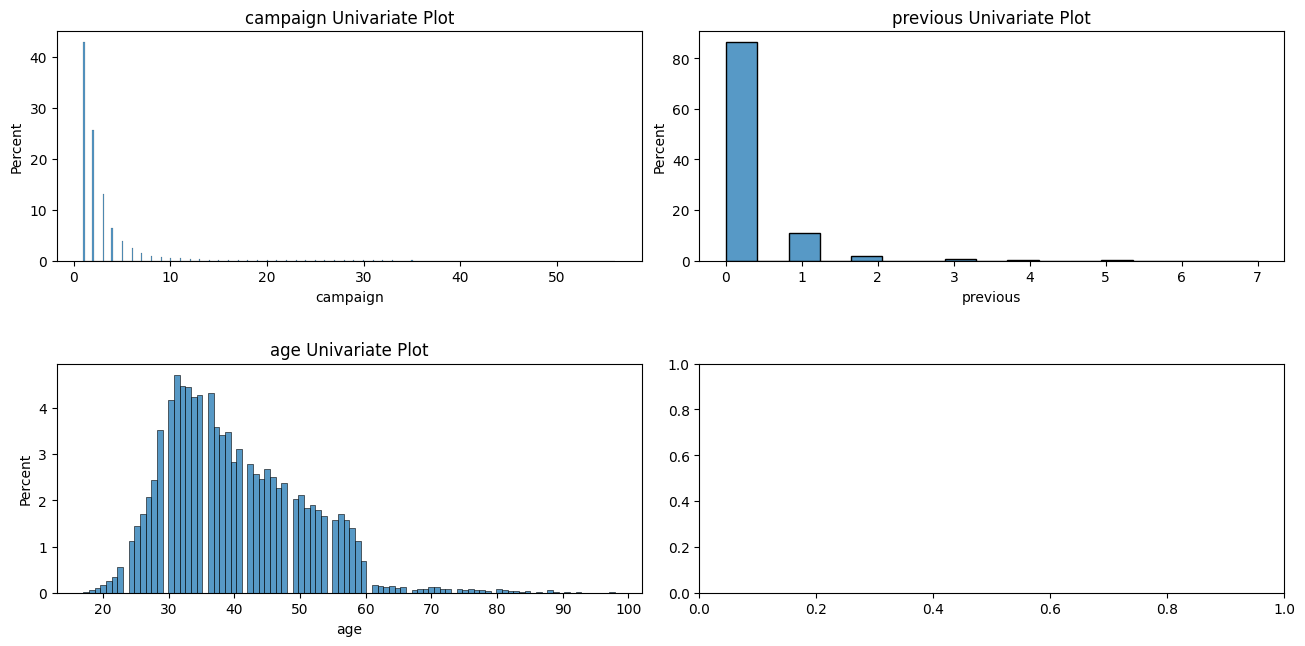

In [19]:
from scipy.stats import skew


def get_skewed_features(df, numerical_columns, skew_threshold=0.75):
    print(f"High data skew features :")
    skew_feat_scores = df[numerical_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewed_feats = skew_feat_scores[skew_feat_scores > 0.75]
    return skewed_feats


print(get_skewed_features(cp_train_df, all_numerical_columns))

skewed_variables = ["campaign", "previous", "age"]
univariate_plot_for_variables(
    cp_train_df, skewed_variables, n_cols=2, figsize_x=13, figsize_y=3, top_in_betweeen_subplot_spacing=2.0
)


##  3.4.1 Fix Data Skew :

- Log transformation : Used for age, campaign and previous
    - Transforms skewed distribution to normal distribution
    - Must be applied prior to scaling, as it leads to nan values for negative numbers.
    - +1 to ensure data 
- Root: For large values
    - Square root : When values are too large + for positive values only
    - Cube rooot : Can handle positive / negative  values
- Squared : For left skewed data



In [20]:
if "log_age" not in cp_train_df.columns:
    # Not scaled yet, create checkpoint
    cp_train_df_ckpt_2 = cp_train_df.copy()
    cp_test_df_ckpt_2 = cp_test_df.copy()
else:
    cp_train_df = cp_train_df_ckpt_2.copy()
    cp_test_df = cp_test_df_ckpt_2.copy()


def handle_data_skew(df):
    epsilon = 0.001
    df["log_campaign"] = df["campaign"].apply(lambda x: np.log(x + epsilon))
    df["log_previous"] = df["previous"].apply(lambda x: np.log(x + epsilon))
    df["log_age"] = df["age"].apply(lambda x: np.log(x + epsilon))

    get_skewed_features(df, all_numerical_columns)
    return df


cp_train_df = handle_data_skew(cp_train_df)
cp_test_df = handle_data_skew(cp_test_df)


cols = list(ckpt_data_cp_train_post_missing_value.columns)
cols.remove("y")
cols.remove("age")
cols.remove("campaign")
cols.remove("previous")
cols_ckpt_data_cp_train_post_missing_n_categorical_encoding_n_skewness = cols.copy()
ckpt_data_cp_train_post_missing_n_categorical_encoding_n_skewness = cp_train_df.copy()


High data skew features :
High data skew features :


### 3.5 Feature Scaling :
- Some models i.e Decision Tree are robust to unscaled data, however regression, NNs, KNNs, k-means are extremely sensitive to unscaled features. Causes all sorts of problem ranging from incorrect modeling to  unstable model to non-convergence.

Proper scaling should be choosen becuase we have preserved the outliers in our data and some scaling are  sennsitive or highly affected with outliers presence.

1. StandardScaler : Very Outlier sensitive because mean and sd are sensitive to outliers.
2. MinMaxscaler : Very Outlier sensitive
3. MaxAbsScaler : Outlier sensitive
4. RobustScaler : Centering and scaling based on percentiles,hence less outliers ensitive + Outliers  in transformed data are preserved.
5. QuantileTransformer : Outlier sensitive but outliers are clipped.

We will choose RobustScaler to scale  while also preserving the outliers in our data.



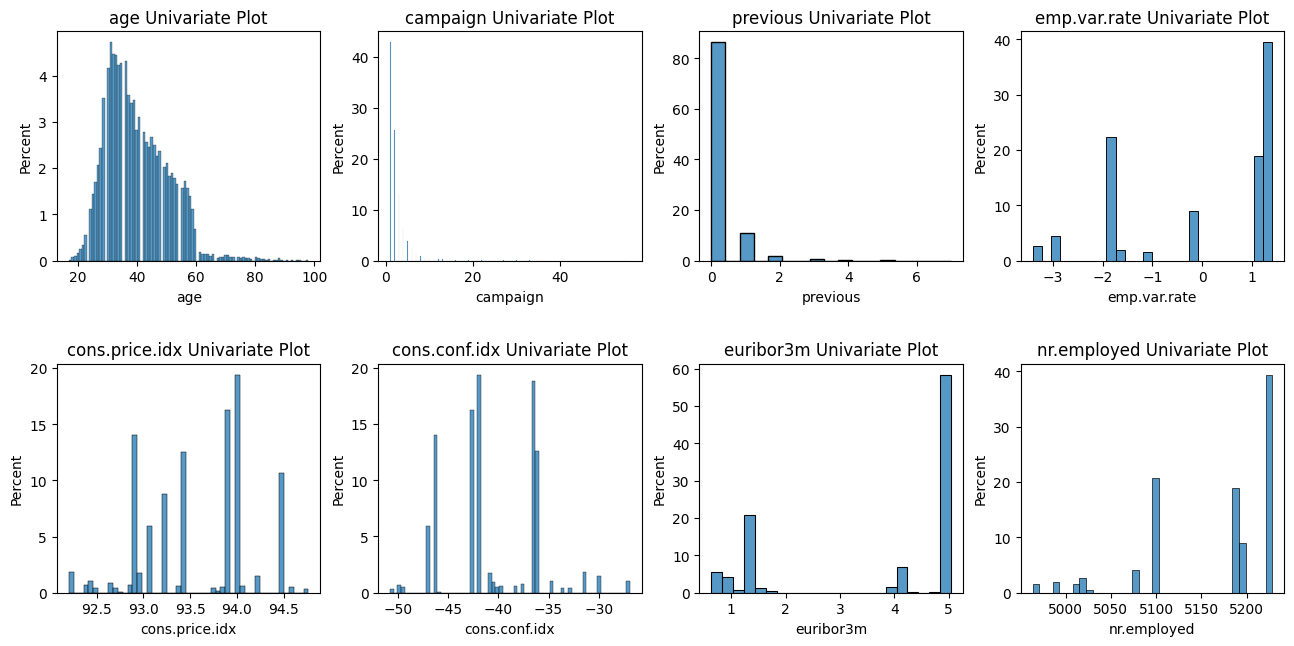

In [21]:
# cp_train_df[all_numerical_columns].describe()
univariate_plot_for_variables(
    cp_train_df, all_numerical_columns, n_cols=4, figsize_x=13, figsize_y=3, top_in_betweeen_subplot_spacing=2.0
)


#### 3.5.1 Fix Scaling:

New Scaled Columns created ['scl_age', 'scl_log_age', 'scl_cons.price.idx', 'scl_cons.conf.idx', 'scl_nr.employed']
Creating Training Scaler
New Scaled Columns created ['scl_age', 'scl_log_age', 'scl_cons.price.idx', 'scl_cons.conf.idx', 'scl_nr.employed']


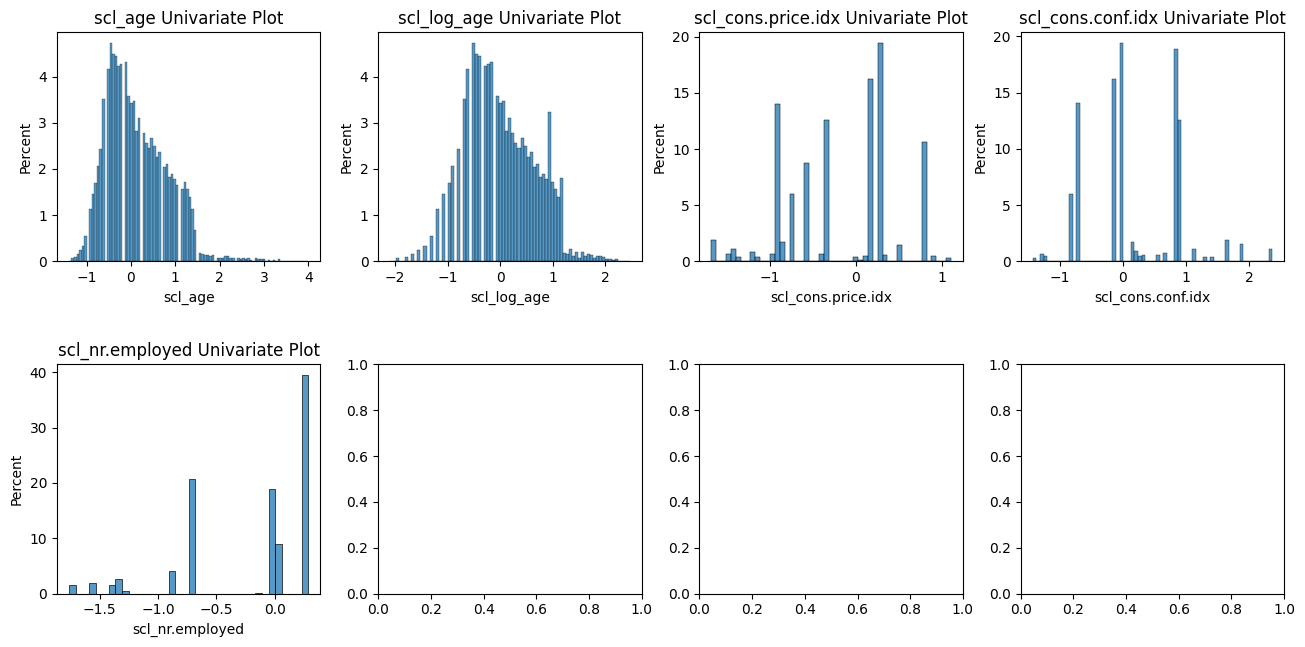

In [22]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler


def handle_variable_scaling(df, all_numerical_columns, is_train_data=True, scaler=None):
    to_scale_columns = []
    for col in all_numerical_columns:
        df["scl_" + col] = df[col]
        to_scale_columns.append("scl_" + col)

    print(f"New Scaled Columns created {to_scale_columns}")

    if is_train_data:
        print("Creating Training Scaler")
        scaler = RobustScaler()
        scaler.fit(df[to_scale_columns])

    df[to_scale_columns] = scaler.transform(df[to_scale_columns])
    return df, scaler


numerical_columns_to_scale = ["age", "log_age", "cons.price.idx", "cons.conf.idx", "nr.employed"]
cp_train_df, scaler_from_training = handle_variable_scaling(cp_train_df, numerical_columns_to_scale, is_train_data=True)
cp_test_df, _ = handle_variable_scaling(
    cp_test_df, numerical_columns_to_scale, is_train_data=False, scaler=scaler_from_training
)


scaled_columns = ["scl_age", "scl_log_age", "scl_cons.price.idx", "scl_cons.conf.idx", "scl_nr.employed"]
# Comparing pre and post-scaling plots
univariate_plot_for_variables(
    cp_train_df, scaled_columns, n_cols=4, figsize_x=13, figsize_y=3, top_in_betweeen_subplot_spacing=2.0
)

# cols_ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling = cols.copy()
ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling = cp_train_df.copy()
ckpt_data_cp_test_post_missing__categorical_encoding__skewness__scaling = cp_test_df.copy()

cp_train_df = ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling.copy()
cp_test_df = ckpt_data_cp_test_post_missing__categorical_encoding__skewness__scaling.copy()


### 3.6 Correlation :
- Because correlation causes problems during modeling. Unstable model at best and non-coverging models at worst. 

<AxesSubplot: >

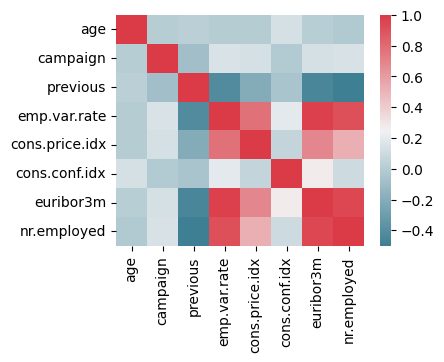

In [23]:
import numpy as np

correlation = cp_train_df[all_numerical_columns].corr()

f, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(correlation, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)


In [24]:
def get_highly_correlated_variables(df: pd.DataFrame, threshold: float):
    xCorr = df.corr()
    xFiltered = xCorr[((xCorr >= threshold) | (xCorr <= -threshold)) & (xCorr != 1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened


def is_same_column_variant(col1, col2):
    if len(col1) > len(col2):
        col1, col2 = col2, col1

    smaller_name_col, longer_name_col = col1, col2
    return smaller_name_col in longer_name_col


def get_removal_recommendation_for_highly_correlated_variables(highly_correlated_variables, cp_train_df):
    """Remove variables with lowest variance"""
    cor_df = pd.DataFrame(highly_correlated_variables.reset_index())
    cor_df.columns = ["variable_1", "variable_2", "correlation"]
    cor_df["variance_var1"] = cor_df["variable_1"].apply(lambda x: cp_train_df[x].var())
    cor_df["variance_var2"] = cor_df["variable_2"].apply(lambda x: cp_train_df[x].var())

    cor_df["recommended_removal"] = cor_df.apply(
        lambda row: row["variable_1"] if row["variance_var1"] < row["variance_var2"] else row["variable_2"], axis=1
    )

    cor_df["is_same_col_variant"] = cor_df.apply(
        lambda row: is_same_column_variant(row["variable_1"], row["variable_2"]), axis=1
    )
    cor_df = cor_df[cor_df.is_same_col_variant == False]
    return cor_df.sort_values(by=["correlation"])


all_number_columns = list(cp_train_df.select_dtypes(include="number").columns)
highly_correlated_variables_df = get_highly_correlated_variables(cp_train_df[all_number_columns], 0.8)
highly_correlated_variables_with_removal_recommendation = get_removal_recommendation_for_highly_correlated_variables(
    highly_correlated_variables_df, cp_train_df
)
highly_correlated_variables_with_removal_recommendation


,variable_1,variable_2,correlation,variance_var1,variance_var2,recommended_removal,is_same_col_variant
0,pdays,pcontacted,-1.000000,0.035397,0.035397,pcontacted,False
1,log_previous,poutcome_nonexistent,-0.998600,5.902333,0.117814,poutcome_nonexistent,False
2,poutcome_success,pdays,-0.950117,0.032183,0.035397,poutcome_success,False
3,previous,poutcome_nonexistent,-0.878624,0.244863,0.117814,poutcome_nonexistent,False
4,poutcome_nonexistent,poutcome_failure,-0.853179,0.117814,0.092498,poutcome_failure,False
5,log_previous,poutcome_failure,0.844363,5.902333,0.092498,poutcome_failure,False
8,nr.employed,emp.var.rate,0.906926,5220.991372,2.467139,emp.var.rate,False
9,emp.var.rate,scl_nr.employed,0.906926,2.467139,0.313743,scl_nr.employed,False
10,euribor3m,scl_nr.employed,0.945136,3.007803,0.313743,scl_nr.employed,False
11,euribor3m,nr.employed,0.945136,3.007803,5220.991372,euribor3m,False


####  3.6.1 Fix Correlation :
- We will remove highly correlated variables  based on their variance.
- Removing variables emp.var.rate & euribor3m because they have high correlation. 

In [25]:
def handle_highly_correlated_variables(df, highly_correlated_variables):
    df.drop(columns=highly_correlated_variables, inplace=True)
    return df


highly_correlated_variables = [
    "emp.var.rate",
    "poutcome_nonexistent",
    "poutcome_failure",
    "poutcome_success",
    "euribor3m",
]
cp_train_df = handle_highly_correlated_variables(cp_train_df, highly_correlated_variables)
cp_test_df = handle_highly_correlated_variables(cp_test_df, highly_correlated_variables)

print("emp.var.rate" in set(cp_train_df.columns))
all_numerical_columns.remove("emp.var.rate")
all_numerical_columns.remove("euribor3m")

ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr = cp_train_df.copy()


cols = list(ckpt_data_cp_train_post_missing_n_categorical_encoding.columns)
cols.remove("y")
cols.remove("emp.var.rate")
cols.remove("euribor3m")
cols_ckpt_data_cp_train_post_missing_n_categorical_encoding_corr = cols.copy()
ckpt_data_cp_train_post_missing_n_categorical_encoding_corr = (
    ckpt_data_cp_train_post_missing_n_categorical_encoding.copy()
)
ckpt_data_cp_train_post_missing_n_categorical_encoding_corr.drop(columns=["emp.var.rate", "euribor3m"], inplace=True)


False


### 3.6.2 Correlation Fix : Verfification
-  Use the following code, ot inspect further more high correlation.
- As we can see, all columns except exclusive variable are highly correlated.e.g we will use either age or log_age in  training, but not both. These variables are same variables represented in diff form

In [26]:
all_number_columns = list(cp_train_df.select_dtypes(include="number").columns)
highly_correlated_variables_df = get_highly_correlated_variables(cp_train_df[all_number_columns], 0.8)
highly_correlated_variables_with_removal_recommendation = get_removal_recommendation_for_highly_correlated_variables(
    highly_correlated_variables_df, cp_train_df
)
highly_correlated_variables_with_removal_recommendation


,variable_1,variable_2,correlation,variance_var1,variance_var2,recommended_removal,is_same_col_variant
0,pdays,pcontacted,-1.00000,0.035397,0.035397,pcontacted,False
3,scl_log_age,scl_age,0.98667,0.436172,0.482583,scl_log_age,False
4,scl_age,log_age,0.98667,0.482583,0.064451,log_age,False


### 3.7 Feature Selection : Variance Threshold
We will remove features that have low variance or variability (i.e features that are close to zero).
- No Variable Removed. Because In our case, there are no variables with very low variance.
- Why ?
    - Because features with low variance or variability  do not provide any information to a ML model for learning the pattern.
- How ?
    - Dummmy variables are expected to have low variance, hence we will exclude them from the analysis here.
    - Variance is range dependent, hence  scaling is very important prior to this step.



In [27]:
cp_train_df[all_numerical_columns].var().sort_values()[0:30]

previous             0.244863
cons.price.idx       0.334945
campaign             7.661737
cons.conf.idx       21.409889
age                108.581110
nr.employed       5220.991372
dtype: float64

In [ ]:
asdasdasd

## Export : Modeling Ready Data

### 4. Modeling





### 4.1 Dataset creation:  Train/ Valid
- Split Train Data into Train/ Valid - 70-30%
- Test Data : From bank-additional.csv. cp_test_df

In [28]:
## Sanity Check
assert len(cp_train_df.columns) == len(cp_test_df.columns)


## DataSet Creation
def get_stratified_data(X_df, y_series, test_size=0.2, verbose=False, seed=4):
    from sklearn.model_selection import StratifiedShuffleSplit

    feature_cols = list(X_df.columns)
    # target_col = y_df.columns

    X = np.array(X_df)
    y = np.array(y_series)

    sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=seed)
    sss.get_n_splits(X, y)

    for train_index, test_index in sss.split(X, y):
        if verbose:
            print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    X_train = pd.DataFrame(X_train, columns=feature_cols)
    X_test = pd.DataFrame(X_test, columns=feature_cols)

    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)

    if verbose:
        print(f"\n ...No. of Training Data : {len(X_train)}")
        print(f" ...No. of Test Data     : {len(X_test)}")
        print(f" ...No. of Features : {len(X_train.columns)}")
        print(f" ...Train Bincount : {np.bincount(y_train[0])}")
        print(f" ...Test Bincount  : {np.bincount(y_test[0])}")

    return X_train, y_train, X_test, y_test


### 4.2 Evaluation Metric Selection:

- Accuracy is a bad Evaluation metric given  highly imbalanced nature of Data.
- We will choose recall, F1-score and additionally use confusion matrix. 
- In our case, recall is more important because  we have few no. of positive cases and we want to include as much as possible at a acceptable cost incurred(i.e Failure rate). we want to find all positive AOP(account opening propensity while minimising the  negative AOP)
- Recall : Ability of model to find all positive classes
- Precision : Ability of model to not label as positive a sample that is negative.
- Balanced accuracy ; avg of recall across all classes.


In [29]:
from sklearn.model_selection import cross_validate

scoring = ["recall", "precision", "accuracy", "balanced_accuracy", "f1", "roc_auc"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from typing import List
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn import tree
from sklearn.model_selection import cross_validate


# Defining the confusion matrix function
def plot_confusion_matrix(cm, class_labels, title="Confusion matrix", cmap=plt.cm.Blues):
    import itertools

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def eval_classification(y_test, ypred_test, class_labels=["Retained", "Churn - Lost"], title="Confusion Matrix"):
    print("Confusion report is")
    print(classification_report(y_test, ypred_test))
    conf_matrix = confusion_matrix(y_test, ypred_test)
    plot_confusion_matrix(conf_matrix, class_labels=class_labels, title=title)
    return conf_matrix


def plot_roc(y_test: List[int], y_test_proba: List[float]):
    auc = roc_auc_score(y_test, y_test_proba)
    print("Logistic: ROC AUC=%.3f" % (auc))

    # # keep probabilities for the positive outcome only
    # probability_positive_class = y_test_proba[:, 1]
    probability_positive_class = y_test_proba

    fpr, tpr, _ = roc_curve(y_test, probability_positive_class)

    pyplot.plot(fpr, tpr, marker=".", label="")
    pyplot.title("ROC Curve")
    pyplot.xlabel("False Positive Rate (False Alarm Rate)")
    pyplot.ylabel("True Positive Rate ( Sensitivity, Hit Rate)")
    pyplot.legend()
    pyplot.show()


def plot_roc_for_binary_prediction_label(y_test, y_test_prediction):
    from plot_metric.functions import BinaryClassification

    bc = BinaryClassification(y_test, y_test_prediction, labels=["Class 1", "Class 2"])
    # Figures
    plt.figure(figsize=(5, 5))
    bc.plot_roc_curve()
    plt.show()


def create_new_score_tracker_df(scoring):
    score_tracker_dict = {"model_name": []}
    scores = {}
    for cur_scoring in scoring:
        score_tracker_dict.update({cur_scoring: []})

    score_tracker_df = pd.DataFrame(score_tracker_dict)
    return score_tracker_df


def add_cv_score_to_df(df, model_descriptor_name, scoring, cur_clf_cv_result):
    cur_scores = {"model_name": model_descriptor_name}
    for cur_scoring in scoring:
        cur_scores.update({cur_scoring: round(cur_clf_cv_result["test_" + cur_scoring].mean(), 2)})

    df = df.append(cur_scores, ignore_index=True)
    df = df.drop_duplicates(keep="last")
    return df


def get_cv_scores(clf, model_descriptor_name, X, y, scoring, score_tracker_df=None, cv_fold=5):
    # Create Score tracker df if first run
    if score_tracker_df is None:
        print("Created New Score Tracker")
        score_tracker_df = create_new_score_tracker_df(scoring)

    cur_clf_cv_result = cross_validate(clf, X, y, cv=cv_fold, scoring=scoring)
    score_tracker_df = add_cv_score_to_df(score_tracker_df, model_descriptor_name, scoring, cur_clf_cv_result)

    return score_tracker_df


def simple_tree(X_trainR, y_trainR, X_testR, y_testR, max_depth=None, class_weight=None, class_labels=["yes", "no"]):
    from sklearn import tree

    clf = tree.DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weight)
    clf.fit(X_trainR, y_trainR)
    ypred_testR = clf.predict(X_testR)

    eval_classification(y_testR, ypred_testR, class_labels=class_labels)
    return clf


In [30]:
# ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr.columns
base_cols_to_use_training = [
    "default",
    "housing",
    "loan",
    "contact",
    "job_admin.",
    "job_blue-collar",
    "job_entrepreneur",
    "job_housemaid",
    "job_management",
    "job_retired",
    "job_self-employed",
    "job_services",
    "job_student",
    "job_technician",
    "job_unemployed",
    "marital_divorced",
    "marital_married",
    "marital_single",
    "day_of_week_fri",
    "day_of_week_mon",
    "day_of_week_thu",
    "day_of_week_tue",
    "day_of_week_wed",
    "month_apr",
    "month_aug",
    "month_dec",
    "month_jul",
    "month_jun",
    "month_mar",
    "month_may",
    "month_nov",
    "month_oct",
    "month_sep",
    "education_basic.4y",
    "education_basic.6y",
    "education_basic.9y",
    "education_high.school",
    "education_professional.course",
    "education_university.degree",
    "education_illiterate",
]

log_scaled_cols_to_use_training = base_cols_to_use_training + [
    "pcontacted",
    "log_campaign",
    "log_previous",
    "scl_log_age",
    "scl_cons.price.idx",
    "scl_cons.conf.idx",
    "scl_nr.employed",
]

all_cols_to_use_training = [
    "pcontacted",
    "pdays",
    "campaign",
    "log_campaign",
    "previous",
    "log_previous",
    "age",
    "log_age",
    "scl_age",
    "scl_log_age",
    "cons.price.idx",
    "scl_cons.price.idx",
    "cons.conf.idx",
    "scl_cons.conf.idx",
    "nr.employed",
    "scl_nr.employed",
]


### 4.3 Benchmark Model : Simple Tree

TRAIN: [ 6489 14637 29668 ... 39919 10991 34281] TEST: [17761 16766  4580 ...  4368 14541  6045]
TRAIN: [29759  6332 32279 ...  8879     2 15336] TEST: [13166 25973 33308 ... 38388 12354 32702]

 ...No. of Training Data : 28765
 ...No. of Test Data     : 12328
 ...No. of Features : 47
 ...Train Bincount : [25526  3239]
 ...Test Bincount  : [10940  1388]
Confusion report is
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     10940
           1       0.31      0.32      0.31      1388

    accuracy                           0.84     12328
   macro avg       0.61      0.61      0.61     12328
weighted avg       0.85      0.84      0.84     12328



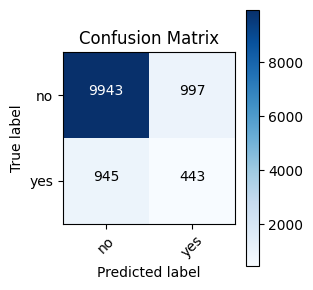

In [31]:
X_all = cp_train_df[log_scaled_cols_to_use_training]
y_all = cp_train_df["y"]
X_train, y_train, X_valid, y_valid = get_stratified_data(X_all, y_all, test_size=0.3, verbose=True)


assert (
    X_train.isnull().sum().sum() == 0
), "ERROR: Missing values has cripped up during preprocessing. Invetigate and Fix"
simple_tree_clf = simple_tree(X_train, y_train, X_valid, y_valid, class_weight=None, class_labels=["no", "yes"])


In [32]:
scoring = ["recall", "precision", "accuracy", "balanced_accuracy", "f1", "roc_auc"]
score_tracker_df = get_cv_scores(
    clf=tree.DecisionTreeClassifier(max_depth=None, class_weight=None),
    X=X_train,
    y=y_train,
    cv_fold=5,
    scoring=scoring,
    model_descriptor_name="Simple Tree Unbalanced",
    score_tracker_df=None,
)
score_tracker_df = get_cv_scores(
    clf=tree.DecisionTreeClassifier(max_depth=None, class_weight="balanced"),
    X=X_train,
    y=y_train,
    cv_fold=5,
    scoring=scoring,
    model_descriptor_name="Simple Tree balanced",
    score_tracker_df=score_tracker_df,
)
score_tracker_df


Created New Score Tracker


,model_name,recall,precision,accuracy,balanced_accuracy,f1,roc_auc
0,Simple Tree Unbalanced,0.34,0.3,0.84,0.62,0.32,0.62
1,Simple Tree balanced,0.32,0.3,0.84,0.61,0.31,0.61


####  4.3.1 Multiple Tree model @ Diff Data Check Points
- By running models across different  data points pre & post data preprocessing, we can get a general feel of if any preprocessing steps are too aggresive or unwanted.
- Constant random state seed used for reproducible results. It controls the randomnedd of the training and testing set indices


In [33]:
def get_benchmark_cv_scores(clf, x_columns, df, model_name, score_tracker_df=None):
    if x_columns is None:
        x_columns = list(df.columns)
        x_columns.remove("y")
    print(f" Columns : {len(x_columns)}")
    cur_X_train, cur_y_train, _, _ = get_stratified_data(df[x_columns], df["y"], test_size=0.01, seed=4)
    score_tracker_df = get_cv_scores(
        clf=clf,
        X=cur_X_train,
        y=cur_y_train,
        cv_fold=5,
        scoring=scoring,
        model_descriptor_name=model_name,
        score_tracker_df=score_tracker_df,
    )
    return score_tracker_df


x_columns = log_scaled_cols_to_use_training
tree_clf = tree.DecisionTreeClassifier(max_depth=None, class_weight=None)
# score_tracker_df = get_benchmark_cv_scores(tree_clf, ckpt_data_cp_train_post_missing_value,
#                             'Tree-Fix-MissVal', score_tracker_df)
cur_cols = list(ckpt_data_cp_train_post_missing_n_categorical_encoding.columns)
cur_cols.remove("y")
cols_ckpt_data_cp_train_post_missing_n_categorical_encoding = cur_cols
score_tracker_df = get_benchmark_cv_scores(
    tree_clf,
    None,
    ckpt_data_cp_train_post_missing_n_categorical_encoding,
    "Tree-Fix-MissVal-CatEncode",
    score_tracker_df,
)

x_cols = list(ckpt_data_cp_train_post_missing_n_categorical_encoding_n_skewness.columns)
x_cols.remove("age")
x_cols.remove("campaign")
x_cols.remove("previous")
x_cols.remove("y")
cols_ckpt_data_cp_train_post_missing_n_categorical_encoding_n_skewness = x_cols.copy()
score_tracker_df = get_benchmark_cv_scores(
    tree_clf,
    x_cols,
    ckpt_data_cp_train_post_missing_n_categorical_encoding_n_skewness,
    "Tree-Fix-MissVal-CatEncode-Skew",
    score_tracker_df,
)

cols = list(ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling.columns)
cols.remove("age")
cols.remove("campaign")
cols.remove("previous")
cols.remove("y")
cols.remove("log_age")
cols.remove("scl_age")
cols.remove("cons.price.idx")
cols.remove("cons.conf.idx")
cols.remove("nr.employed")
cols_ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling = cols.copy()
score_tracker_df = get_benchmark_cv_scores(
    tree_clf,
    cols,
    ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling,
    "Tree-Fix-MissVal-CatEncode-Skew-Scale",
    score_tracker_df,
)


cols = list(ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr.columns)
cols.remove("age")
cols.remove("campaign")
cols.remove("previous")
cols.remove("y")
cols.remove("log_age")
cols.remove("scl_age")
cols.remove("cons.price.idx")
cols.remove("cons.conf.idx")
cols.remove("nr.employed")
cols_ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr = cols.copy()
score_tracker_df = get_benchmark_cv_scores(
    tree_clf,
    cols,
    ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr,
    "Tree-Fix-MissVal-CatEncode-Skew-Scale-Corr",
    score_tracker_df,
)

score_tracker_df


 Columns : 53
 Columns : 53
 Columns : 53
 Columns : 48


,model_name,recall,precision,accuracy,balanced_accuracy,f1,roc_auc
0,Simple Tree Unbalanced,0.34,0.30,0.84,0.62,0.32,0.62
1,Simple Tree balanced,0.32,0.30,0.84,0.61,0.31,0.61
2,Tree-Fix-MissVal-CatEncode,0.34,0.31,0.84,0.62,0.33,0.63
3,Tree-Fix-MissVal-CatEncode-Skew,0.34,0.31,0.84,0.62,0.32,0.63
4,Tree-Fix-MissVal-CatEncode-Skew-Scale,0.33,0.31,0.84,0.62,0.32,0.62
5,Tree-Fix-MissVal-CatEncode-Skew-Scale-Corr,0.33,0.30,0.84,0.62,0.32,0.62


### 4.4 Modeling : Logistic Regression
-  Because LR is more complex than Tree and is explainable, we will try them.

In [34]:
from sklearn.linear_model import LogisticRegression


C = 0.0001
lr_clf = LogisticRegression(penalty="l2", C=C, class_weight="balanced", max_iter=100000)
# lr_clf = LogisticRegression(penalty='l2',C=0.0001,class_weight='balanced')


score_tracker_df = get_benchmark_cv_scores(
    lr_clf,
    cols_ckpt_data_cp_train_post_missing_n_categorical_encoding,
    ckpt_data_cp_train_post_missing_n_categorical_encoding,
    "LR-Fix-MissVal-CatEncode-C_" + str(C),
    score_tracker_df,
)

cols = list(ckpt_data_cp_train_post_missing_n_categorical_encoding_corr.columns)
cols.remove("y")
cols_ckpt_data_cp_train_post_missing_n_categorical_encoding_corr = cols.copy()
score_tracker_df = get_benchmark_cv_scores(
    lr_clf,
    cols_ckpt_data_cp_train_post_missing_n_categorical_encoding_corr,
    ckpt_data_cp_train_post_missing_n_categorical_encoding_corr,
    "LR-Fix-MissVal-CatEncode-Corr-C_" + str(C),
    score_tracker_df,
)

score_tracker_df = get_benchmark_cv_scores(
    lr_clf,
    cols_ckpt_data_cp_train_post_missing_n_categorical_encoding_n_skewness,
    ckpt_data_cp_train_post_missing_n_categorical_encoding_n_skewness,
    "LR-Fix-MissVal-CatEncode-Skew-C_" + str(C),
    score_tracker_df,
)
score_tracker_df = get_benchmark_cv_scores(
    lr_clf,
    cols_ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling,
    ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling,
    "LR-Fix-MissVal-CatEncode-Skew-Scale-C_" + str(C),
    score_tracker_df,
)
score_tracker_df = get_benchmark_cv_scores(
    lr_clf,
    cols_ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr,
    ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr,
    "LR-Fix-MissVal-CatEncode-Skew-Scale-Corr-C_" + str(C),
    score_tracker_df,
)

print("5 Fold CV Results")
score_tracker_df


 Columns : 53
 Columns : 51
 Columns : 53


KeyboardInterrupt: 

#### 4.4.1 LogisticRegression Model Comparisions
- LR Across Data Checkpoints
- We will look into three LR models in more details.
    - LR-Fix-MissVal-CatEncode	0.59
    - LR-Fix-MissVal-CatEncode-Skew-Scale	0.70
    - LR-Fix-MissVal-CatEncode-Skew-Scale-Corr	0.67
    - surprisingly Removing correlateed variable seems to be dropping the recall.

-  Comparing  LR model with  MissVal and Cat Encoding PreProcessor vs all, because the recall dropped at the expense of precision and there is minimal change in other scores. 
- If performance is comparable, simple transformation allows for better  and easily explained model.
- We will hence use data checkpoint with 
    - Missing Value PreProcessing
    - Categorical Encoding
    - Correlation (Coz, it introduces multi-colinearity and unstable Logistic Regression model)

In [ ]:
def get_train_test_data_from_df(df, x_columns=None, test_size=0.2):
    if x_columns is None:
        x_columns = list(df.columns)
        x_columns.remove("y")
    cur_X_train, cur_y_train, cur_x_test, cur_y_test = get_stratified_data(df[x_columns], df["y"], test_size=test_size)
    return cur_X_train, cur_y_train, cur_x_test, cur_y_test


def train_lr(cur_X_train, cur_y_train, cur_x_test, cur_y_test, c=0.0001):
    lr_clf = LogisticRegression(penalty="l2", C=c, class_weight="balanced", max_iter=100000)
    lr_clf.fit(cur_X_train, cur_y_train)
    y_test_predicted = lr_clf.predict(cur_x_test)

    eval_classification(y_test=cur_y_test, ypred_test=y_test_predicted, class_labels=["no AOP", "yes AOP"])


##### 4.4.1.1 LR : Missing Value + Categorical Encoded Only

Confusion report is
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      7294
           1       0.26      0.73      0.38       925

    accuracy                           0.73      8219
   macro avg       0.61      0.73      0.61      8219
weighted avg       0.88      0.73      0.78      8219



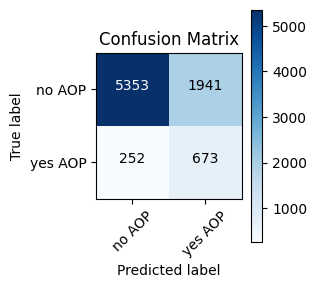

In [ ]:
x_columns = cols_ckpt_data_cp_train_post_missing_n_categorical_encoding
data = ckpt_data_cp_train_post_missing_n_categorical_encoding
cur_X_train, cur_y_train, cur_x_test, cur_y_test = get_train_test_data_from_df(data, x_columns=x_columns)
train_lr(cur_X_train, cur_y_train, cur_x_test, cur_y_test, c=0.0001)


##### 4.4.1.2 LR : Missing Value + Categorical Encoded + Skew + Scaled Data

Confusion report is
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      7294
           1       0.25      0.73      0.38       925

    accuracy                           0.73      8219
   macro avg       0.60      0.73      0.60      8219
weighted avg       0.88      0.73      0.78      8219



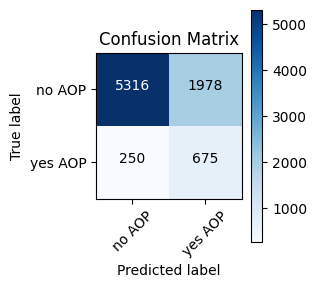

In [ ]:
x_columns = cols_ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling
data = ckpt_data_cp_train_post_missing__categorical_encoding__skewness__scaling
cur_X_train, cur_y_train, cur_x_test, cur_y_test = get_train_test_data_from_df(data, x_columns=x_columns)
train_lr(cur_X_train, cur_y_train, cur_x_test, cur_y_test, c=0.0001)


##### 4.4.1.3 LR : Missing Value + Categorical Encoded + Skew + Scaled Data + Correlation Fixed

Confusion report is
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7294
           1       0.31      0.61      0.42       925

    accuracy                           0.81      8219
   macro avg       0.63      0.72      0.65      8219
weighted avg       0.87      0.81      0.83      8219



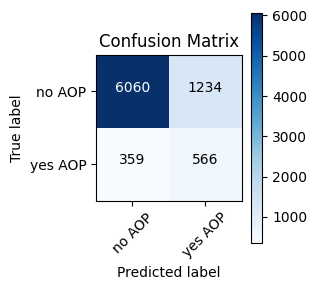

In [ ]:
x_columns = cols_ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr
data = ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr
cur_X_train, cur_y_train, cur_x_test, cur_y_test = get_train_test_data_from_df(data, x_columns=x_columns)
train_lr(cur_X_train, cur_y_train, cur_x_test, cur_y_test, c=0.0001)


#### 4.4.2 LR Model Choosen: LR + All Preprocessing  applied

#### 4.4.3 Future To Dos : More PreProcessing
- Test  further more processing especially with scaling and clipping of outlier values with variable, as Logistic Regression is especially sensistive to them.


#### 4.4.4 LR + Imbalanced Data Fix
- Testing differnent balancing strategies to check for model improvement with LR.


[0class 1class] =   [25526 25526]
[0class 1class] =   [29172 29172]
Confusion report is
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      7294
           1       0.30      0.66      0.42       925

    accuracy                           0.79      8219
   macro avg       0.63      0.73      0.65      8219
weighted avg       0.88      0.79      0.82      8219



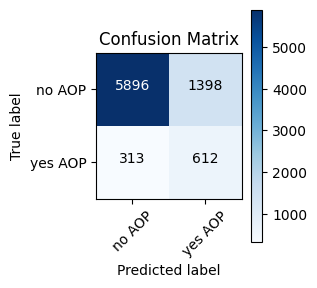

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=4)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print("[0class 1class] =  ", np.bincount(y_train_smote[0]))


def train_lr_with_smote(df, x_columns=None, test_size=0.2, c=0.0001):
    cur_train_df = df.copy()
    if x_columns is None:
        x_columns = list(df.columns)
        x_columns.remove("y")

    cur_X_train, cur_y_train, cur_x_test, cur_y_test = get_stratified_data(
        cur_train_df[x_columns], cur_train_df["y"], test_size=test_size
    )

    ## Apply Smote to balance data
    sm = SMOTE(random_state=4)
    cur_X_train, cur_y_train = sm.fit_resample(cur_X_train, cur_y_train)
    print("[0class 1class] =  ", np.bincount(cur_y_train[0]))

    lr_clf = LogisticRegression(penalty="l2", C=c, class_weight="balanced", max_iter=100000)
    lr_clf.fit(cur_X_train, cur_y_train)
    y_test_predicted = lr_clf.predict(cur_x_test)

    eval_classification(y_test=cur_y_test, ypred_test=y_test_predicted, class_labels=["no AOP", "yes AOP"])

    return cur_X_train, cur_y_train


x_columns = cols_ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr
smote_x_train, smote_y_train = train_lr_with_smote(
    ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr, x_columns, test_size=0.2
)


##### 4.4.4.1 LR + Smote : Conclusion
- Data Balanced Performance is comparable to LR's Model weight balanced approach. 



## 4.5 Model Evaluation : Test set
Model Evaluation against Unseen Test Data
- We will explore and understand the Logistic Regression model to understand what features are relevant  and by what factor. Because we have used different transformation, we must be careful while making interpretation for those transformation applied variables.



Confusion report is
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      3657
           1       0.24      0.70      0.35       450

    accuracy                           0.72      4107
   macro avg       0.59      0.71      0.59      4107
weighted avg       0.87      0.72      0.77      4107



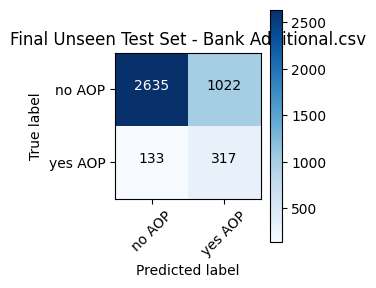

array([[2635, 1022],
       [ 133,  317]])

In [ ]:
# print(len(cp_test_df))
x_columns = list(cur_X_train.columns)
bank_additional_X_test = cp_test_df[x_columns]
bank_additional_y_test = cp_test_df["y"]

cols = cols_ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr
data = ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr
cur_X_train, cur_y_train, cur_x_test, cur_y_test = get_train_test_data_from_df(data, x_columns=cols)


# C : Regularisation strenght. Small values implies stronger regularisation
lr_clf = LogisticRegression(penalty="l1", C=0.0009, solver="saga", class_weight="balanced", max_iter=100000)
# lr_clf = LogisticRegression(penalty='l2', C=0.0001, solver='newton-cholesky', class_weight="balanced", max_iter=100000)
lr_clf.fit(cur_X_train, cur_y_train)

y_test_proba_bank_additional = lr_clf.predict_proba(bank_additional_X_test)
bank_additional_y_test_predicted = lr_clf.predict(bank_additional_X_test)
eval_classification(
    y_test=bank_additional_y_test,
    ypred_test=bank_additional_y_test_predicted,
    class_labels=["no AOP", "yes AOP"],
    title="Final Unseen Test Set - Bank Additional.csv",
)


#### 4.5.1 Final Model : ROC Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Logistic: ROC AUC=0.751


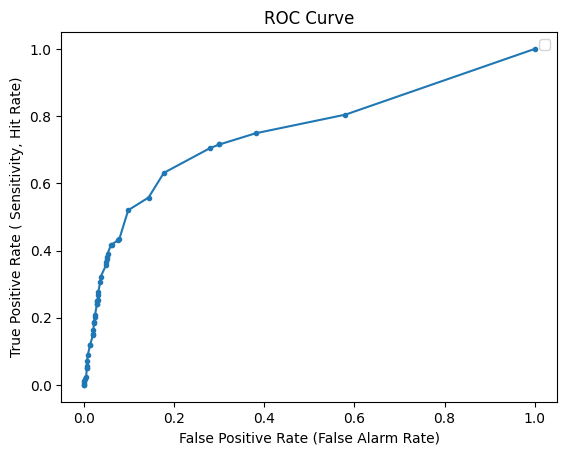

In [ ]:
positive_class_label_list = list(bank_additional_y_test)
positive_class_probability_list = y_test_proba_bank_additional[:, 1]
plot_roc(positive_class_label_list, positive_class_probability_list)

### 4.5.2 Final Model Precision-Recall Curve

Auc : 0.3504658629845612


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


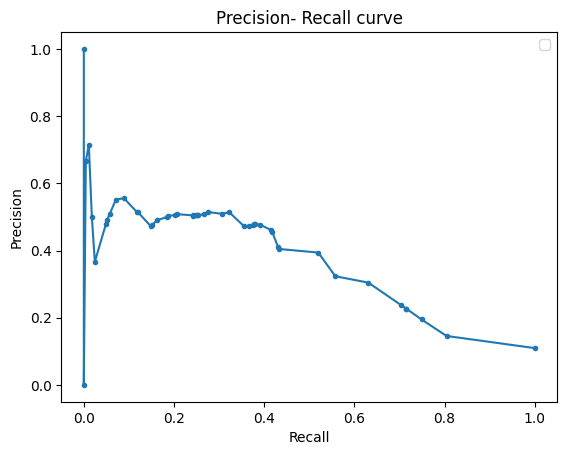

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, auc


def plot_precision_recall_curve(testy, lr_probs):
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_auc = auc(lr_recall, lr_precision)
    print(f"Auc : {lr_auc}")
    pyplot.plot(lr_recall, lr_precision, marker=".", label="")
    pyplot.title("Precision- Recall curve")
    pyplot.xlabel("Recall")
    pyplot.ylabel("Precision")
    pyplot.legend()
    pyplot.show()


plot_precision_recall_curve(positive_class_label_list, positive_class_probability_list)


###  5 Modeling with StatsModel : Explainable Models
- Modeling with statsmodels library , as they provide more statistical details related to models and coeficients and resutls.
- For easier explanation purpose, we will use not  original columns

Ref: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html




In [ ]:
# ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr.columns
base_cols_to_use_training = [
    "default",
    "housing",
    "loan",
    "contact",
    "job_admin.",
    "job_blue-collar",
    "job_entrepreneur",
    "job_housemaid",
    "job_management",
    "job_retired",
    "job_self-employed",
    "job_services",
    "job_student",
    "job_technician",
    "job_unemployed",
    "marital_divorced",
    "marital_married",
    "marital_single",
    "day_of_week_fri",
    "day_of_week_mon",
    "day_of_week_thu",
    "day_of_week_tue",
    "day_of_week_wed",
    "month_apr",
    "month_aug",
    "month_dec",
    "month_jul",
    "month_jun",
    "month_mar",
    "month_may",
    "month_nov",
    "month_oct",
    "month_sep",
    "education_basic.4y",
    "education_basic.6y",
    "education_basic.9y",
    "education_high.school",
    "education_professional.course",
    "education_university.degree",
    "education_illiterate",
]

log_scaled_cols_to_use_training = base_cols_to_use_training + [
    "pcontacted",
    "log_campaign",
    "log_previous",
    "scl_log_age",
    "scl_cons.price.idx",
    "scl_cons.conf.idx",
    "scl_nr.employed",
]

all_cols_to_use_training = [
    "pcontacted",
    "pdays",
    "campaign",
    "log_campaign",
    "previous",
    "log_previous",
    "age",
    "log_age",
    "scl_age",
    "scl_log_age",
    "cons.price.idx",
    "scl_cons.price.idx",
    "cons.conf.idx",
    "scl_cons.conf.idx",
    "nr.employed",
    "scl_nr.employed",
]

cols = cols_ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr
data = ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr


### 5.0 Feature Engineering:
- We broke the age into categorical features, because the p-value was too large for age and breaking down lead to more but not all significant coeficient for age_categories.
- Also tested combining housing_loan and personal_loan into one has_loan feature without any postive coeficient significance impact success. Hence tested and reverted it back to keeping both variables.

In [ ]:
## Age Break
data["age_seniors"] = data["age"].apply(lambda x: 1 if x >= 65 else 0)
data["adult_25_35"] = data["age"].apply(lambda x: 1 if x >= 25 and x < 35 else 0)
data["adult_35_45"] = data["age"].apply(lambda x: 1 if x >= 35 and x < 45 else 0)
data["adult_45_55"] = data["age"].apply(lambda x: 1 if x >= 45 and x < 55 else 0)
data["adult_55_65"] = data["age"].apply(lambda x: 1 if x >= 55 and x < 65 else 0)
# Combine housing and personal_loan to has_loan
# data['has_loan'] = data.apply(lambda row: 1 if row['loan']==1 or row['housing']==1 else 0, axis=1 )


base_cols_to_use_training = base_cols_to_use_training + [
    "loan",
    "housing",
    "age_seniors",
    "adult_25_35",
    "adult_35_45",
    "adult_45_55",
    "adult_55_65",
]

# 'cons.price.idx', scl_nr_employed
base_explainable_cols = (
    base_cols_to_use_training + ["y", "pcontacted", "cons.conf.idx", "scl_nr.employed"] + ["campaign", "previous"]
)


scaled_cols = base_cols_to_use_training + [
    "y",
    "education_illiterate",
    "pcontacted",
    "log_campaign",
    "log_previous",
    "scl_log_age",
    "scl_cons.price.idx",
    "scl_cons.conf.idx",
    "scl_nr.employed",
]


###  5.1 Further Pre-Processing : Multi-colinearity (df-1)
- Transform dummy variable into n-1 variables, because nth variable can be perfectly explained by 1,2,... n-1 variables 
- We will remove the nth variable and during interpretation we will use it as a reference variable to make the explanations.
- Removing :
    - job: remove job_unemployed
    - month : remove dec i.e year end, with more vacations
    - marital : remove single. 
    - day_of_week : remove friday i.e day before weekend.    


In [ ]:
# reference_columns_to_remove = ['education_illiterate', 'job_unemployed','month_dec', 'marital_single', 'day_of_week_fri', 'default_miss' ]
reference_columns_to_remove = [
    "default_miss",
    "education_university.degree",
    "day_of_week_mon",
    "month_aug",
    "marital_single",
    "job_blue-collar",
]
explainable_cols = list(set(base_explainable_cols) - set(reference_columns_to_remove))
scaled_cols = list(set(scaled_cols) - set(reference_columns_to_remove))


def normalise_column_names(df):
    for col in list(df.columns):
        if col == "y":
            continue

        if "." in col or "-" in col:
            # print('Replacing col ', col, col.replace(".","_").replace("-","_"))
            df.rename(columns={col: col.replace(".", "_").replace("-", "_")}, inplace=True)
    # print(df.columns)
    return df


def get_df_n_formulae(df, columns, class_label="y"):
    df = df[columns]
    df = normalise_column_names(df)
    normalised_column_names = sorted(list(df.columns))
    # independent_variables = list(data_df.columns)

    if class_label in normalised_column_names:
        normalised_column_names.remove(class_label)

    return df, class_label + " ~ " + " + ".join(normalised_column_names)


data_df = ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr.copy()
explainable_data_df, explainable_formulae = get_df_n_formulae(data_df, explainable_cols, class_label="y")

data_df = ckpt_data_cp_train_post_missing__cat_encode__skew__scale__corr.copy()
scaled_data_df, scalable_formulae = get_df_n_formulae(data_df, scaled_cols, class_label="y")


### 5.2 Logistic Regression : With Explainable Variables
- Scaling   or scaling+log introduces complexity in  model explanability. Hence we will test both models with n without scaled features. And if both model have acceptable R-squared, AIC and Deviance, we will select the model with explainable variables  in favor of explainability.

In [ ]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
import cvxopt

logit_model_explainable_variables = logit(explainable_formulae, explainable_data_df).fit_regularized(
    maxiter=100000, method="l1", trim_mode="size", size_trim_tol="auto", auto_trim_tol="auto"
)

lr = logit_model_explainable_variables
logit_model_explainable_variables.summary2()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2774835369810498
            Iterations: 271
            Function evaluations: 277
            Gradient evaluations: 271


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
==============================================================================
Model:                   Logit                Pseudo R-squared:     0.212     
Dependent Variable:      y                    AIC:                  22897.2620
Date:                    2023-02-05 02:01     BIC:                  23293.9473
No. Observations:        41093                Log-Likelihood:       -11403.   
Df Model:                45                   LL-Null:              -14461.   
Df Residuals:            41047                LLR p-value:          0.0000    
Converged:               1.0000               Scale:                1.0000    
No. Iterations:          271.0000                                             
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                     -2.0949   0.1983 -10.5649 0.0000 -2.4835 -1.7063
adult_25_35                   -0.1598   0.0996  -1.6038 0.1088 -0.3551  0.0355
adult_35_45                   -0.2806   0.1053  -2.6638 0.0077 -0.4871 -0.0742
adult_45_55                   -0.2406   0.1104  -2.1796 0.0293 -0.4570 -0.0242
adult_55_65                   -0.0628   0.1212  -0.5181 0.6044 -0.3003  0.1747
age_seniors                    0.2023   0.1615   1.2526 0.2104 -0.1142  0.5188
campaign                      -0.0467   0.0092  -5.0516 0.0000 -0.0648 -0.0286
cons_conf_idx                  0.0187   0.0043   4.3988 0.0000  0.0104  0.0271
contact                        0.4724   0.0525   8.9994 0.0000  0.3695  0.5752
day_of_week_fri                0.2211   0.0577   3.8319 0.0001  0.1080  0.3341
day_of_week_thu                0.2730   0.0553   4.9353 0.0000  0.1646  0.3814
day_of_week_tue                0.2600   0.0570   4.5662 0.0000  0.1484  0.3717
day_of_week_wed                0.3502   0.0567   6.1783 0.0000  0.2391  0.4613
default                       -0.2459   0.0575  -4.2767 0.0000 -0.3586 -0.1332
education_basic_4y            -0.1523   0.0775  -1.9640 0.0495 -0.3043 -0.0003
education_basic_6y             0.0100   0.0935   0.1070 0.9148 -0.1733  0.1933
education_basic_9y            -0.1498   0.0681  -2.1992 0.0279 -0.2833 -0.0163
education_high_school         -0.0975   0.0512  -1.9063 0.0566 -0.1978  0.0027
education_illiterate           0.8249   0.6359   1.2972 0.1946 -0.4215  2.0713
education_professional_course -0.0634   0.0637  -0.9946 0.3200 -0.1883  0.0615
housing                       -0.0275   0.0355  -0.7751 0.4383 -0.0972  0.0421
job_admin_                     0.1518   0.0674   2.2511 0.0244  0.0196  0.2840
job_entrepreneur               0.0905   0.1129   0.8015 0.4228 -0.1308  0.3117
job_housemaid                  0.0215   0.1298   0.1654 0.8686 -0.2329  0.2759
job_management                 0.0794   0.0886   0.8962 0.3701 -0.0942  0.2529
job_retired                    0.1755   0.1114   1.5752 0.1152 -0.0429  0.3939
job_self_employed              0.0860   0.1099   0.7820 0.4342 -0.1295  0.3014
job_services                   0.0106   0.0829   0.1282 0.8980 -0.1518  0.1730
job_student                    0.3172   0.1121   2.8306 0.0046  0.0976  0.5369
job_technician                 0.1126   0.0736   1.5295 0.1261 -0.0317  0.2570
job_unemployed                 0.1370   0.1162   1.1796 0.2382 -0.0907  0.3647
loan                          -0.0316   0.0492  -0.6420 0.5209 -0.1280  0.0648
marital_divorced              -0.0545   0.0682  -0.7994 0.4241 -0.1883  0.0792
marital_married               -0.0090   0.0452  -0.1999 0.8416 -0.0977  0.0796
month_apr                      0.2028   0.0876   2.3159 0.0206  0.0312  0.3745
month_dec                      0.3261   0.1707   1.9105 0.0561 -0.0085  0.6607
month_jul                      0.3339   0.0717   4.6583 0.0000  0.1934  0.4744
month_jun                      0.

<AxesSubplot: xlabel='scl_nr_employed', ylabel='Count'>

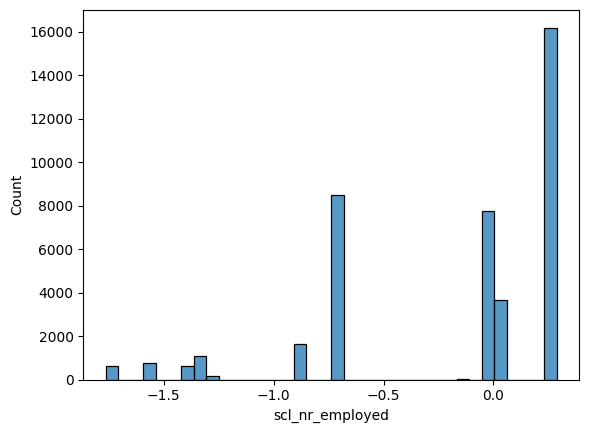

In [ ]:
sns.histplot(explainable_data_df['scl_nr_employed'])

### 5.3 Logistic Regression : Scaled Data Model
 

In [ ]:
logit_scaled_model = logit(scalable_formulae, scaled_data_df).fit_regularized(
    maxiter=100000, method="l1", trim_mode="size", size_trim_tol="auto", auto_trim_tol="auto"
)
lr = logit_scaled_model
logit_scaled_model.summary2()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.27741105336968735
            Iterations: 300
            Function evaluations: 302
            Gradient evaluations: 300


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
==============================================================================
Model:                   Logit                Pseudo R-squared:     0.212     
Dependent Variable:      y                    AIC:                  22895.3048
Date:                    2023-02-05 02:01     BIC:                  23309.2373
No. Observations:        41093                Log-Likelihood:       -11400.   
Df Model:                47                   LL-Null:              -14461.   
Df Residuals:            41045                LLR p-value:          0.0000    
Converged:               1.0000               Scale:                1.0000    
No. Iterations:          300.0000                                             
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                     -3.4757   0.2003 -17.3490 0.0000 -3.8684 -3.0831
adult_25_35                   -0.1492   0.1177  -1.2677 0.2049 -0.3799  0.0815
adult_35_45                   -0.2601   0.1594  -1.6323 0.1026 -0.5725  0.0522
adult_45_55                   -0.2128   0.2069  -1.0284 0.3038 -0.6183  0.1927
adult_55_65                   -0.0271   0.2448  -0.1106 0.9119 -0.5069  0.4527
age_seniors                    0.2394   0.3109   0.7699 0.4414 -0.3700  0.8488
contact                        0.4778   0.0600   7.9641 0.0000  0.3602  0.5954
day_of_week_fri                0.2214   0.0577   3.8363 0.0001  0.1083  0.3344
day_of_week_thu                0.2690   0.0554   4.8590 0.0000  0.1605  0.3775
day_of_week_tue                0.2598   0.0570   4.5564 0.0000  0.1480  0.3715
day_of_week_wed                0.3480   0.0568   6.1321 0.0000  0.2368  0.4593
default                       -0.2435   0.0576  -4.2263 0.0000 -0.3564 -0.1306
education_basic_4y            -0.1489   0.0775  -1.9202 0.0548 -0.3009  0.0031
education_basic_6y             0.0118   0.0937   0.1255 0.9001 -0.1718  0.1953
education_basic_9y            -0.1436   0.0681  -2.1075 0.0351 -0.2771 -0.0100
education_high_school         -0.0936   0.0512  -1.8282 0.0675 -0.1939  0.0067
education_illiterate           0.8278   0.6345   1.3047 0.1920 -0.4158  2.0714
education_professional_course -0.0585   0.0637  -0.9185 0.3583 -0.1834  0.0664
housing                       -0.0292   0.0356  -0.8201 0.4122 -0.0988  0.0405
job_admin_                     0.1510   0.0675   2.2386 0.0252  0.0188  0.2832
job_entrepreneur               0.0919   0.1129   0.8142 0.4156 -0.1293  0.3131
job_housemaid                  0.0225   0.1298   0.1736 0.8622 -0.2318  0.2769
job_management                 0.0770   0.0886   0.8690 0.3849 -0.0967  0.2508
job_retired                    0.1753   0.1117   1.5703 0.1163 -0.0435  0.3942
job_self_employed              0.0866   0.1100   0.7876 0.4309 -0.1290  0.3022
job_services                   0.0121   0.0829   0.1455 0.8843 -0.1503  0.1745
job_student                    0.2973   0.1137   2.6146 0.0089  0.0744  0.5202
job_technician                 0.1141   0.0737   1.5485 0.1215 -0.0303  0.2584
job_unemployed                 0.1336   0.1162   1.1499 0.2502 -0.0941  0.3613
loan                          -0.0307   0.0492  -0.6246 0.5323 -0.1272  0.0657
log_campaign                  -0.1101   0.0283  -3.8859 0.0001 -0.1657 -0.0546
log_previous                  -0.0740   0.0081  -9.1727 0.0000 -0.0898 -0.0582
marital_divorced              -0.0511   0.0690  -0.7410 0.4587 -0.1863  0.0841
marital_married               -0.0065   0.0459  -0.1413 0.8876 -0.0964  0.0834
month_apr                      0.2431   0.0888   2.7383 0.0062  0.0691  0.4171
month_dec                      0.3540   0.1711   2.0682 0.0386  0.0185  0.6894
month_jul                      0.3553   0.0731   4.8584 0.0000  0.2120  0.4986
month_jun                      0.

### 5.4 Model Selection : Scaled  vs Explainable Variables.
- Both model have equal r-squared of 0.21 and similar AIC scores. Hence for explainable modeling purpose we favored explainable Varaible Model.

### 5.5 Feature importance/ Impact Assesment


In [ ]:
marginal_effect = logit_model_explainable_variables.get_margeff()
marginal_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
adult_25_35                      -0.0126      0.008     -1.604      0.109      -0.028       0.003
adult_35_45                      -0.0220      0.008     -2.664      0.008      -0.038      -0.006
adult_45_55                      -0.0189      0.009     -2.180      0.029      -0.036      -0.002
adult_55_65                      -0.0049      0.010     -0.518      0.604      -0.024       0.014
age_seniors                       0.0159      0.013      1.253      0.210      -0.009       0.041
campaign                         -0.0037      0.001     -5.048      0.000      -0.005      -0.002
cons_conf_idx                     0.0015      0.000      4.407      0.000       0.001       0.002
contact                           0.0371      0.004      8.979      0.000       0.029       0.045
day_of_week_fri                   0.0174      0.005      3.832      0.000       0.008       0.026
day_of_week_thu                   0.0214      0.004      4.936      0.000       0.013       0.030
day_of_week_tue                   0.0204      0.004      4.567      0.000       0.012       0.029
day_of_week_wed                   0.0275      0.004      6.179      0.000       0.019       0.036
default                          -0.0193      0.005     -4.273      0.000      -0.028      -0.010
education_basic_4y               -0.0120      0.006     -1.964      0.050      -0.024   -2.44e-05
education_basic_6y                0.0008      0.007      0.107      0.915      -0.014       0.015
education_basic_9y               -0.0118      0.005     -2.199      0.028      -0.022      -0.001
education_high_school            -0.0077      0.004     -1.906      0.057      -0.016       0.000
education_illiterate              0.0648      0.050      1.297      0.195      -0.033       0.163
education_professional_course    -0.0050      0.005     -0.995      0.320      -0.015       0.005
housing                          -0.0022      0.003     -0.775      0.438      -0.008       0.003
job_admin_                        0.0119      0.005      2.251      0.024       0.002       0.022
job_entrepreneur                  0.0071      0.009      0.802      0.423      -0.010       0.024
job_housemaid                     0.0017      0.010      0.165      0.869      -0.018       0.022
job_management                    0.0062      0.007      0.896      0.370      -0.007       0.020
job_retired                       0.0138      0.009      1.575      0.115      -0.003       0.031
job_self_employed                 0.0068      0.009      0.782      0.434      -0.010       0.024
job_services                      0.0008      0.007      0.128      0.898      -0.012       0.014
job_student                       0.0249      0.009      2.831      0.005       0.008       0.042
job_technician                    0.0088      0.006      1.529      0.126      -0.002       0.020
job_unemployed                    0.0108      0.009      1.180      0.238      -0.007       0.029
loan                             -0.0025      0.004     -0.642      0.521      -0.010       0.005
marital_divorced                 -0.0043      0.005     -0.799      0.424      -0.015       0.006
marital_married                  -0.0007      0.004     -0.200      0.842      -0.008       0.006
month_apr                         0.0159      0.007      2.316      0.021       0.002       0.029
month_dec                         0.0256      0.013      1.911      0.056      -0.001       0.052
month_jul                         0.02

### 5.6 LR Model Confusion Matrix : Diff Threshold

In [ ]:
best_lr = logit_model_explainable_variables
print("Confusion Matrix across different threshold")
print(f"\nThreshold=0.5   \n{best_lr.pred_table(0.5)}")
print(f"\nThreshold=0.4   \n{best_lr.pred_table(0.4)}")
print(f"\nThreshold=0.3   \n{best_lr.pred_table(0.3)}")
print(f"\nThreshold=0.2   \n{best_lr.pred_table(0.2)}")
print(f"\nThreshold=0.1   \n{best_lr.pred_table(0.1)}")
print(f"\nThreshold=0.05  \n{best_lr.pred_table(0.05)}")


Confusion Matrix across different threshold

Threshold=0.5   
[[35916.   550.]
 [ 3566.  1061.]]

Threshold=0.4   
[[35453.  1013.]
 [ 3204.  1423.]]

Threshold=0.3   
[[34439.  2027.]
 [ 2633.  1994.]]

Threshold=0.2   
[[33132.  3334.]
 [ 2026.  2601.]]

Threshold=0.1   
[[29615.  6851.]
 [ 1579.  3048.]]

Threshold=0.05  
[[15230. 21236.]
 [  614.  4013.]]


### 5.6 Future To Dos: LR
- Variable slicing for coeficients with larger p-value
- Add in interaction terms

### 5.7 Modeling - Neural Network [Exploration Only]
- For Exploration Purpose only [Black Box Model]
- Simple single layer NN
    - For Exploration only, because NN's are more powerful.

#### 5.7.1 Future To Dos:
- Test multi layer NN vs current 1 layer simple NN


In [ ]:
from sklearn.neural_network import MLPClassifier

sm = SMOTE(random_state=4)
nn_X_train, nn_y_train = sm.fit_resample(cur_X_train, cur_y_train)
print("[0class 1class] =  ", np.bincount(cur_y_train[0]))

nn = MLPClassifier(
    hidden_layer_sizes=(200,), activation="relu", solver="adam", max_iter=100000, tol=0.001, shuffle=True
)
nn_model = nn.fit(nn_X_train, nn_y_train)


[0class 1class] =   [29172  3702]


Confusion report is
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      7294
           1       0.18      0.67      0.28       925

    accuracy                           0.61      8219
   macro avg       0.56      0.64      0.50      8219
weighted avg       0.85      0.61      0.68      8219



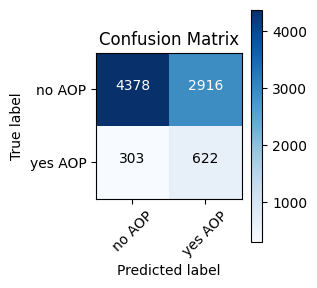

array([[4378, 2916],
       [ 303,  622]])

In [ ]:
y_test_predicted = (nn.predict_proba(cur_x_test)[:, 1] >= 0.06).astype(bool)
eval_classification(cur_y_test, y_test_predicted, class_labels=["no AOP", "yes AOP"])


## 6. Model Explanation:


### 6.1 Top 5 Positive Features
- Previously contacted: People contacted in previous campaigns have 5.8 odds of opening a bank account compared to not contacted ones.
- Months: People are more likely to open account in March(odds: 2.7), June (odds: 1.5), July(odds: 1.4 ), Dec compared to August(lowest rate month)
- Contact: People contacted in cellulars have 1.6 odds of opening a bank compared to people contacted in telephone.
- Day of week : People are more likely to open accounts in Tuesday(odds: 1.3), Wednesday(odds: 1.4), Thursday(odds: 1.3), Friday(odds: 1.2) compared to Monday.
- Occupation: Students(odds : 1.4), retired people(odds : 1.3), or people working in admin(odds : 1.2) are more likely to open accounts compared to blue-collor workers


### 6.2 Top 5 Negative Features
- Number of employees: 1 unit increase in Scaled number of employees decreases opening account propensity by 75%.(5000 scaled to 0 )
- Months: People are less likely to open account in  May(odds: 0.6), Sep(odds: 0.7 ), and Nov(odds:0.8 ) compared to August.
- Age: People of age group 35-45(odds : 0.75), 45-55(odds : 0.8), 25-35(odds : 0.85) have lower odds of opening account.
- Default: People who have defaulted have 0.78 odds of opening account compared to
- Education: People with basic_4y(odds : 0.9), basic_9y(odds : 0.9) have lower odds of account opening compared to university_degree.





In [ ]:
best_lr.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
==============================================================================
Model:                   Logit                Pseudo R-squared:     0.212     
Dependent Variable:      y                    AIC:                  22897.2620
Date:                    2023-02-05 02:02     BIC:                  23293.9473
No. Observations:        41093                Log-Likelihood:       -11403.   
Df Model:                45                   LL-Null:              -14461.   
Df Residuals:            41047                LLR p-value:          0.0000    
Converged:               1.0000               Scale:                1.0000    
No. Iterations:          271.0000                                             
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                     -2.0949   0.1983 -10.5649 0.0000 -2.4835 -1.7063
adult_25_35                   -0.1598   0.0996  -1.6038 0.1088 -0.3551  0.0355
adult_35_45                   -0.2806   0.1053  -2.6638 0.0077 -0.4871 -0.0742
adult_45_55                   -0.2406   0.1104  -2.1796 0.0293 -0.4570 -0.0242
adult_55_65                   -0.0628   0.1212  -0.5181 0.6044 -0.3003  0.1747
age_seniors                    0.2023   0.1615   1.2526 0.2104 -0.1142  0.5188
campaign                      -0.0467   0.0092  -5.0516 0.0000 -0.0648 -0.0286
cons_conf_idx                  0.0187   0.0043   4.3988 0.0000  0.0104  0.0271
contact                        0.4724   0.0525   8.9994 0.0000  0.3695  0.5752
day_of_week_fri                0.2211   0.0577   3.8319 0.0001  0.1080  0.3341
day_of_week_thu                0.2730   0.0553   4.9353 0.0000  0.1646  0.3814
day_of_week_tue                0.2600   0.0570   4.5662 0.0000  0.1484  0.3717
day_of_week_wed                0.3502   0.0567   6.1783 0.0000  0.2391  0.4613
default                       -0.2459   0.0575  -4.2767 0.0000 -0.3586 -0.1332
education_basic_4y            -0.1523   0.0775  -1.9640 0.0495 -0.3043 -0.0003
education_basic_6y             0.0100   0.0935   0.1070 0.9148 -0.1733  0.1933
education_basic_9y            -0.1498   0.0681  -2.1992 0.0279 -0.2833 -0.0163
education_high_school         -0.0975   0.0512  -1.9063 0.0566 -0.1978  0.0027
education_illiterate           0.8249   0.6359   1.2972 0.1946 -0.4215  2.0713
education_professional_course -0.0634   0.0637  -0.9946 0.3200 -0.1883  0.0615
housing                       -0.0275   0.0355  -0.7751 0.4383 -0.0972  0.0421
job_admin_                     0.1518   0.0674   2.2511 0.0244  0.0196  0.2840
job_entrepreneur               0.0905   0.1129   0.8015 0.4228 -0.1308  0.3117
job_housemaid                  0.0215   0.1298   0.1654 0.8686 -0.2329  0.2759
job_management                 0.0794   0.0886   0.8962 0.3701 -0.0942  0.2529
job_retired                    0.1755   0.1114   1.5752 0.1152 -0.0429  0.3939
job_self_employed              0.0860   0.1099   0.7820 0.4342 -0.1295  0.3014
job_services                   0.0106   0.0829   0.1282 0.8980 -0.1518  0.1730
job_student                    0.3172   0.1121   2.8306 0.0046  0.0976  0.5369
job_technician                 0.1126   0.0736   1.5295 0.1261 -0.0317  0.2570
job_unemployed                 0.1370   0.1162   1.1796 0.2382 -0.0907  0.3647
loan                          -0.0316   0.0492  -0.6420 0.5209 -0.1280  0.0648
marital_divorced              -0.0545   0.0682  -0.7994 0.4241 -0.1883  0.0792
marital_married               -0.0090   0.0452  -0.1999 0.8416 -0.0977  0.0796
month_apr                      0.2028   0.0876   2.3159 0.0206  0.0312  0.3745
month_dec                      0.3261   0.1707   1.9105 0.0561 -0.0085  0.6607
month_jul                      0.3339   0.0717   4.6583 0.0000  0.1934  0.4744
month_jun                      0.

### 6.3 Marketing Strategies :

### 6.3.1 Strategies for Increasing Account-opens
- Target people with multiple follow-up campaigns (Previously contacted: 5.8 odds)
- Run more / campaigns  on March(odds: 2.7), June (odds: 1.5), July(odds: 1.4 ), Dec(odds: 1.4 ) and no/ fewer on  May(odds: 0.6), Aug, Sep(odds: 0.7 ), oct(0.97) Nov(odds:0.8 ) 
- Run campaigns, in accordance to the number of employee- quarterly metric. If metric shows decrease, reduce campaigns.
- Target people with cellulars(1.6 odds) over telephone(landline)
- Target people of younger age(15-25). Other age groups have lower odds compared to youth(15-25) i.e 35-45(odds : 0.75), 45-55(odds : 0.8), 25-35(odds : 0.85) 
- Target Students(odds : 1.4), retired people(odds : 1.3), or people working in admin(odds : 1.2) compared to blue-collor workers.
- Target campaign on Tuesday(odds: 1.3), Wednesday(odds: 1.4), Thursday(odds: 1.3), Friday(odds: 1.2) and less on Monday.
- Target defaulted users less (0.78 odds)

### 6.3.2 Strategies For Diversity / WorkForce Management:
- WorkLoad Smoothing: Let’s assume that the bank wants people to open bank accounts uniformly throughout the year so that it can effectively manage work pressure for its staffs. To do so, it can increase its marketing communication in Nov, Sep, May.

- Diversity / Niche Bank Creation : WIth regards to occupation, if bank wants to create a niche, it may want to focus more on students and retire people. If diversification is a priority, a reverse focus on  (reference category) is appropriate. 

Important! : Strategies are exclusive of Future Account Balance Potential.
